In [1]:
# Import libraries, process data, define training and tests sets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from ucimlrepo import fetch_ucirepo 
import time

from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
  
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X_df = default_of_credit_card_clients.data.features 
y_df = default_of_credit_card_clients.data.targets 
  
# metadata 
#print(default_of_credit_card_clients.metadata) 
  
# variable information 
print(default_of_credit_card_clients.variables) 

print(X_df)
print(y_df)

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

In [2]:
print('X2: Gender (1 = male; 2 = female)')
print(X_df.groupby(['X2'])['X2'].count())

print('X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)')
print(X_df.groupby(['X3'])['X3'].count())

print('X4: Marital status (1 = married; 2 = single; 3 = others)')
print(X_df.groupby(['X4'])['X4'].count())

print('Target: default payment (Yes = 1, No = 0)')
print(y_df.groupby(['Y'])['Y'].count())

X2: Gender (1 = male; 2 = female)
X2
1    11888
2    18112
Name: X2, dtype: int64
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
X3
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: X3, dtype: int64
X4: Marital status (1 = married; 2 = single; 3 = others)
X4
0       54
1    13659
2    15964
3      323
Name: X4, dtype: int64
Target: default payment (Yes = 1, No = 0)
Y
0    23364
1     6636
Name: Y, dtype: int64


In [3]:
X_df['X3'].values[X_df['X3'].values >= 4] = 4
X_df['X3'].values[X_df['X3'].values == 0] = 4

X_df['X4'].values[X_df['X4'].values == 0] = 3

print('X2: Gender (1 = male; 2 = female)')
print(X_df.groupby(['X2'])['X2'].count())

print('X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)')
print(X_df.groupby(['X3'])['X3'].count())

print('X4: Marital status (1 = married; 2 = single; 3 = others)')
print(X_df.groupby(['X4'])['X4'].count())

X2: Gender (1 = male; 2 = female)
X2
1    11888
2    18112
Name: X2, dtype: int64
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
X3
1    10585
2    14030
3     4917
4      468
Name: X3, dtype: int64
X4: Marital status (1 = married; 2 = single; 3 = others)
X4
1    13659
2    15964
3      377
Name: X4, dtype: int64


In [4]:
data_df = pd.concat([X_df, y_df], axis=1)

In [5]:
# count the duplicated cases
data_df.duplicated().sum()

35

In [6]:
data_df = data_df.drop_duplicates()
data_df.reset_index(drop=True,inplace=True)

In [7]:
data_df['Y'].value_counts()

0    23335
1     6630
Name: Y, dtype: int64

<Axes: >

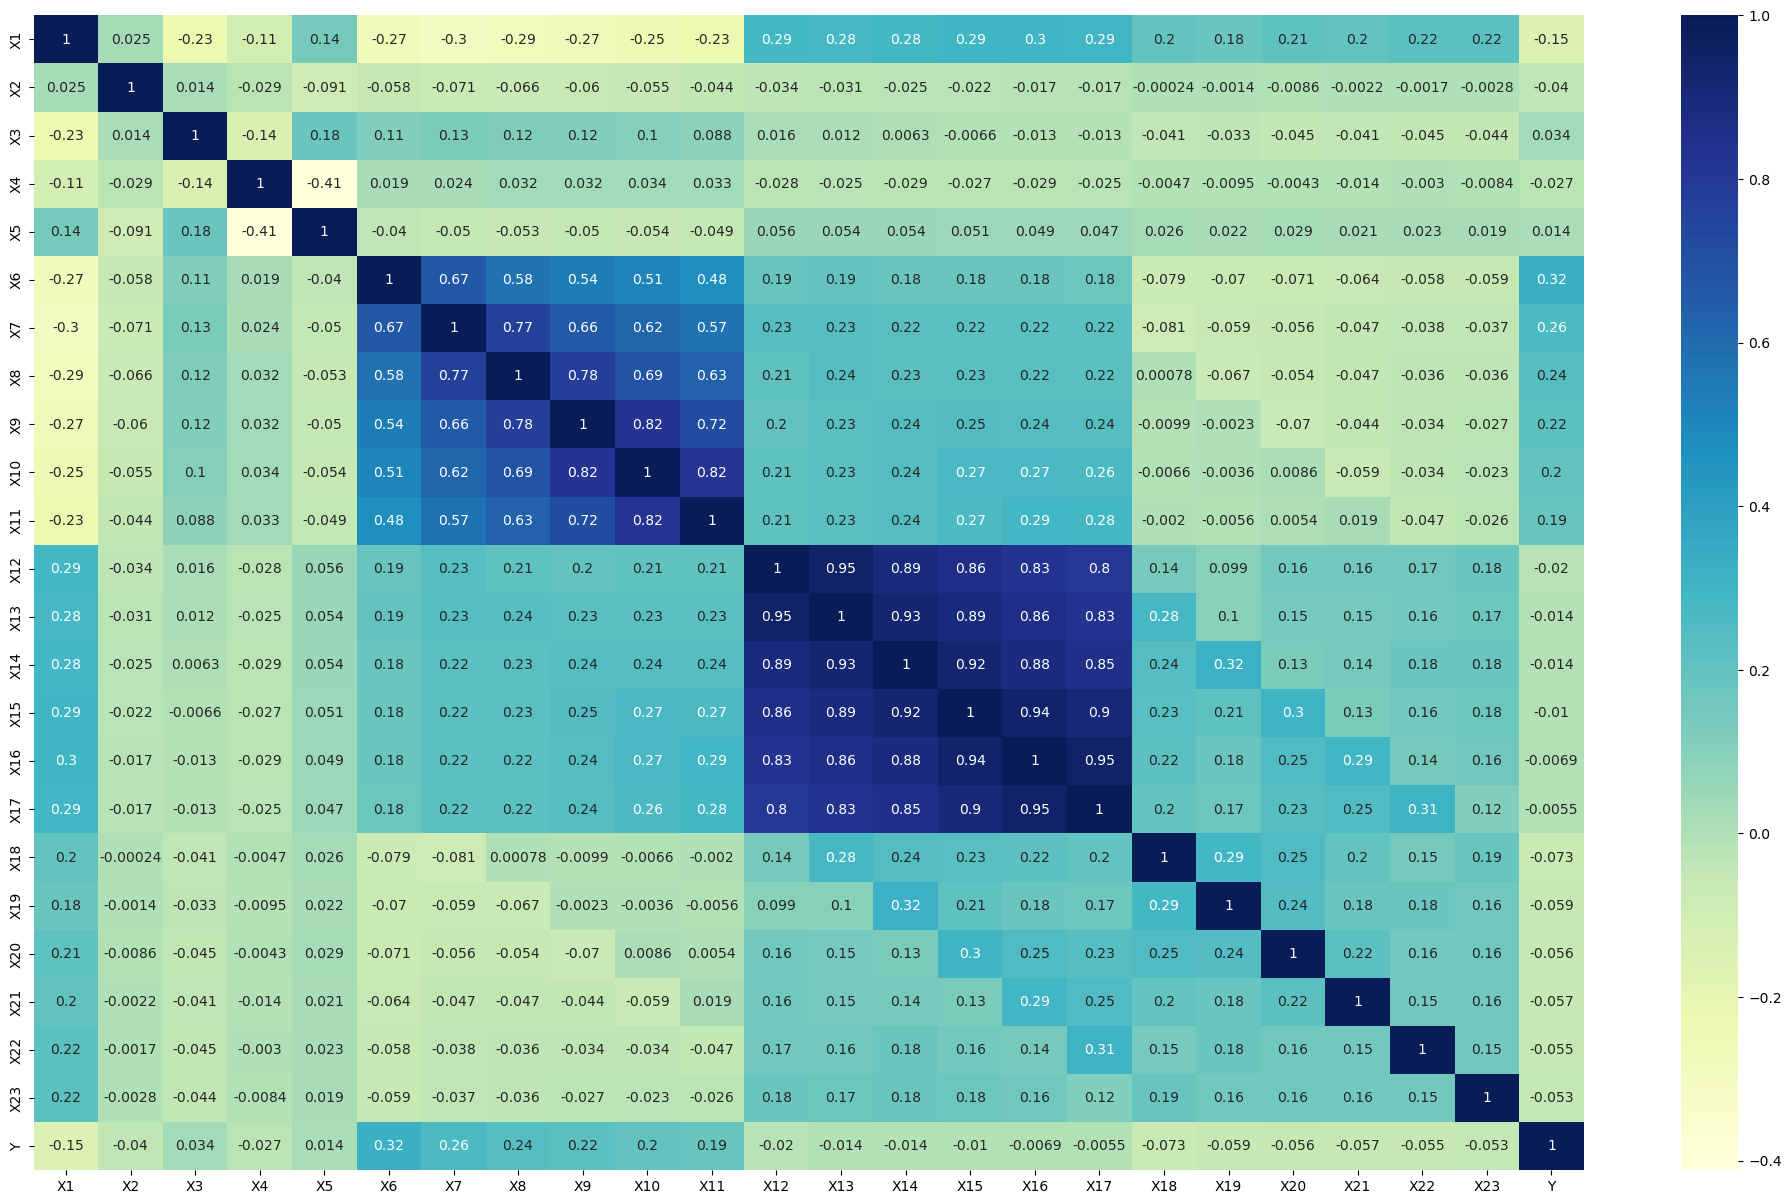

In [8]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data_df.corr(),annot=True,cmap="YlGnBu" , ax=ax)

In [9]:
# Use one-hot-encoding for the categorical feature: X4 {1,2,3}
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data_df[['X4']])
print(enc.categories_)
enc_features_names = enc.get_feature_names_out(['X4'])
enc_features = enc.transform(data_df[['X4']]).toarray()
enc_features_df = pd.DataFrame(enc_features, columns=enc_features_names)

# Feature df
X_df = pd.concat([data_df, enc_features_df], axis=1)
X_df.drop(['X4','Y'], axis=1, inplace=True)

X = X_df.values
y = data_df['Y'].values

[array([1, 2, 3], dtype=int64)]


In [10]:
X_df

,X1,X2,X3,X5,X6,X7,X8,X9,X10,X11,...,X17,X18,X19,X20,X21,X22,X23,X4_1,X4_2,X4_3
0,20000,2,2,24,2,2,-1,-1,-2,-2,...,0,0,689,0,0,0,0,1.0,0.0,0.0
1,120000,2,2,26,-1,2,0,0,0,2,...,3261,0,1000,1000,1000,0,2000,0.0,1.0,0.0
2,90000,2,2,34,0,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0.0,1.0,0.0
3,50000,2,2,37,0,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1.0,0.0,0.0
4,50000,1,2,57,-1,0,-1,0,0,0,...,19131,2000,36681,10000,9000,689,679,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29960,220000,1,3,39,0,0,0,0,0,0,...,15980,8500,20000,5003,3047,5000,1000,1.0,0.0,0.0
29961,150000,1,3,43,-1,-1,-1,-1,0,0,...,0,1837,3526,8998,129,0,0,0.0,1.0,0.0
29962,30000,1,2,37,4,3,2,-1,0,0,...,19357,0,0,22000,4200,2000,3100,0.0,1.0,0.0
29963,80000,1,3,41,1,-1,0,0,0,-1,...,48944,85900,3409,1178,1926,52964,1804,1.0,0.0,0.0


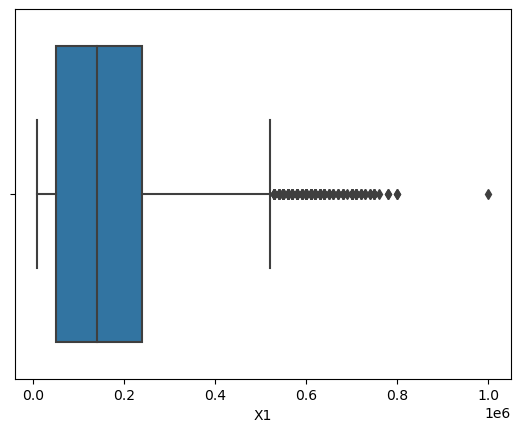

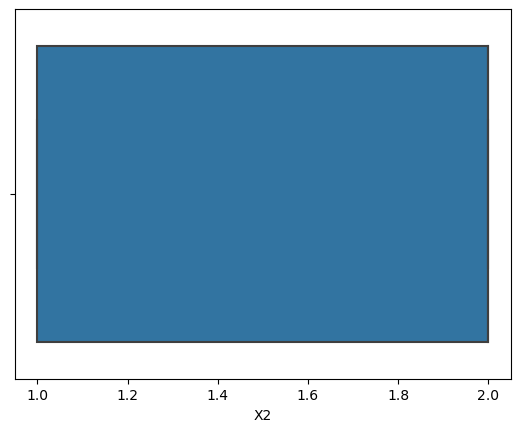

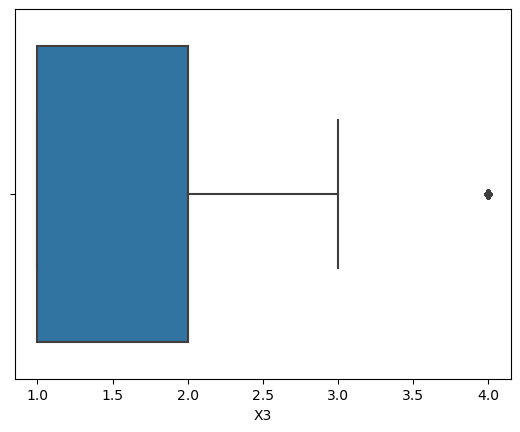

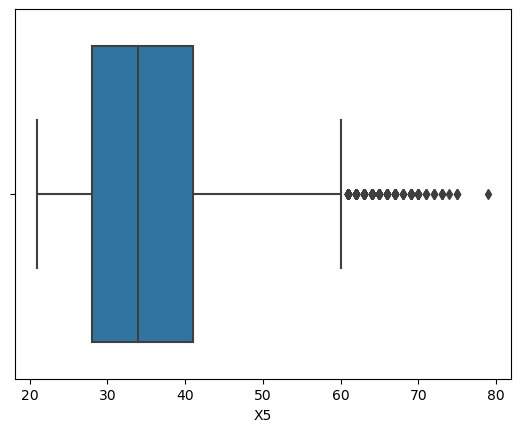

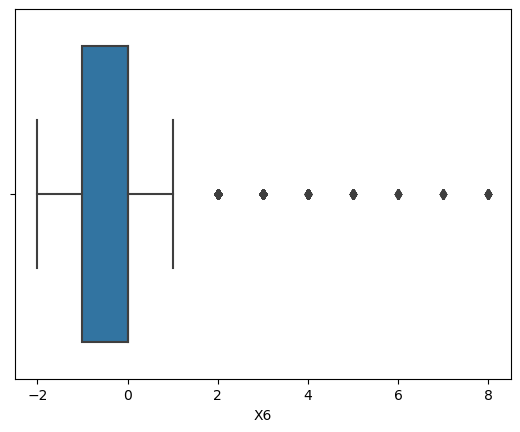

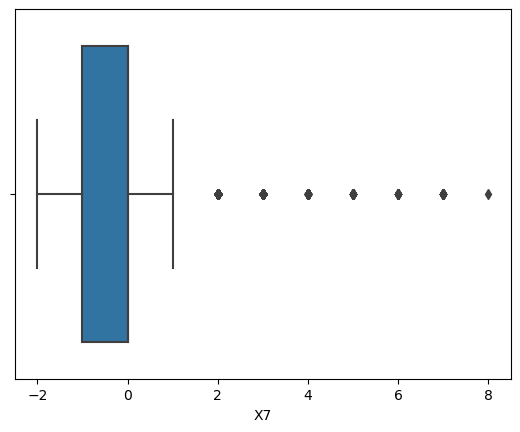

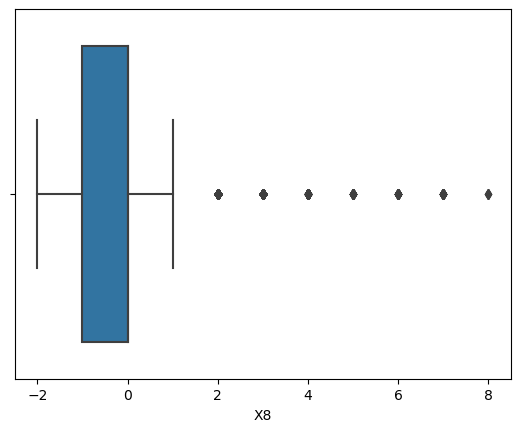

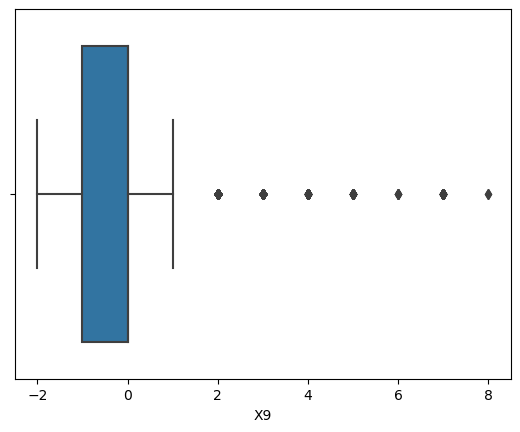

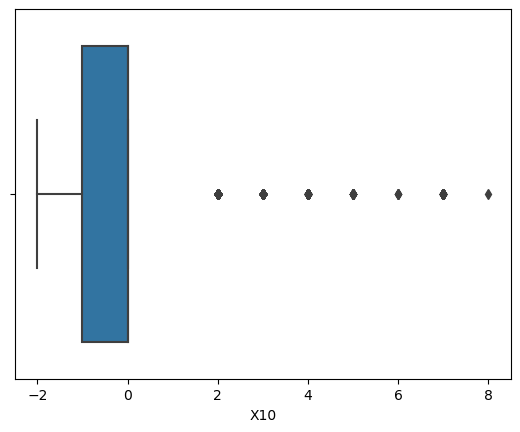

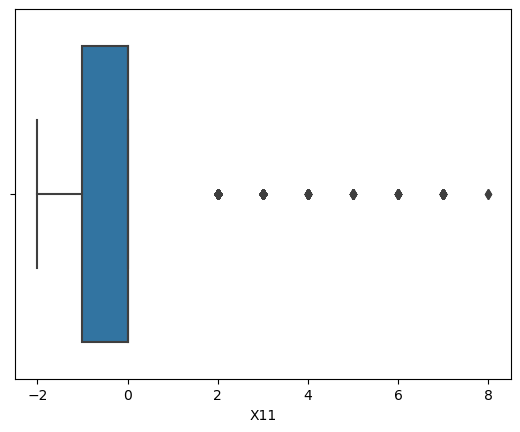

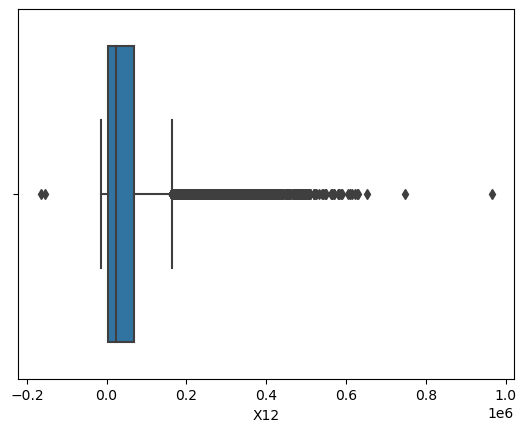

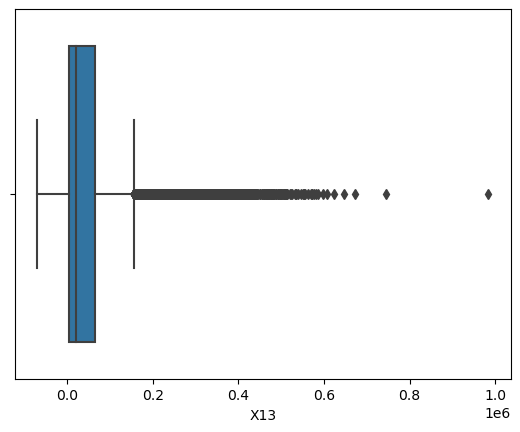

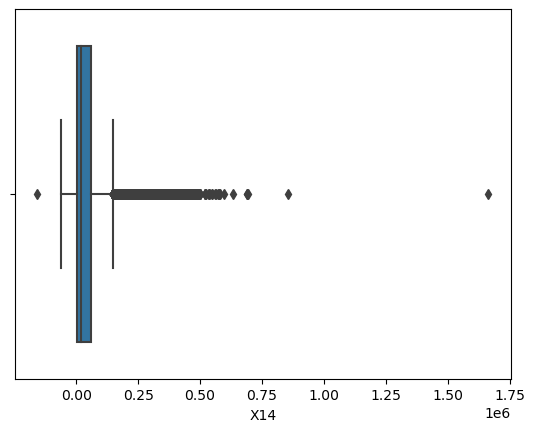

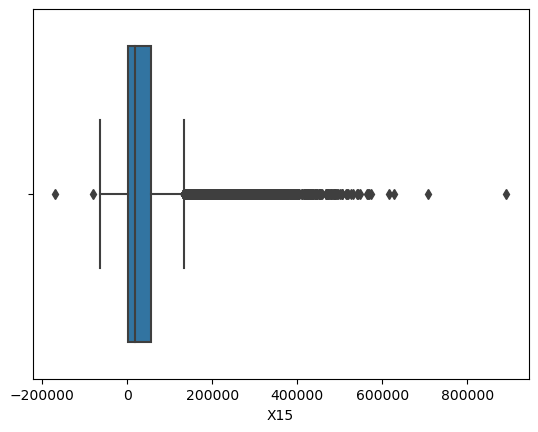

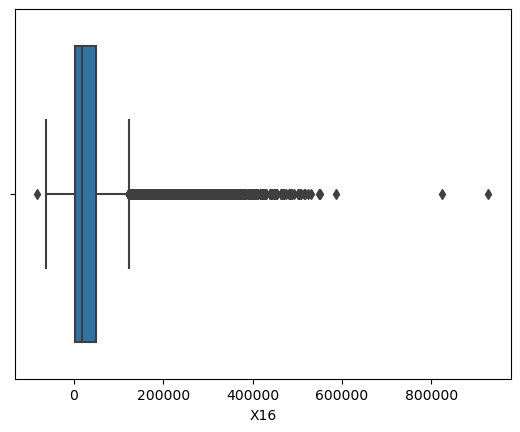

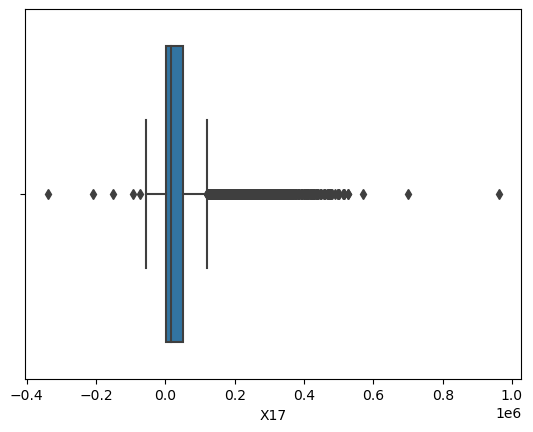

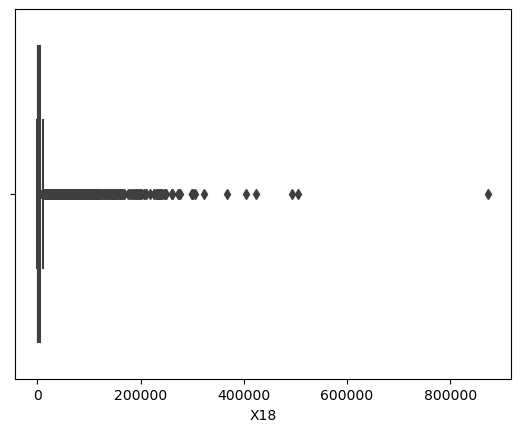

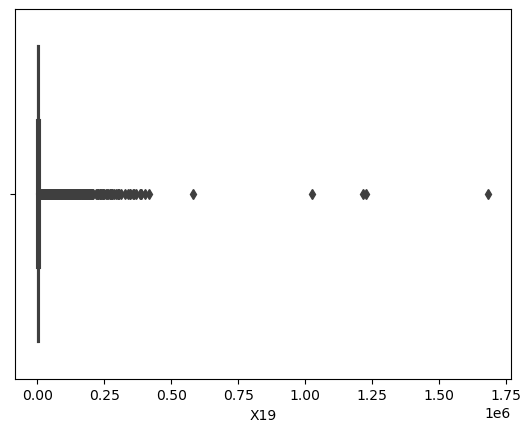

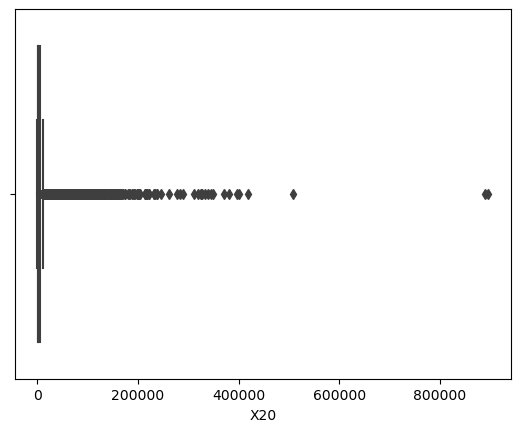

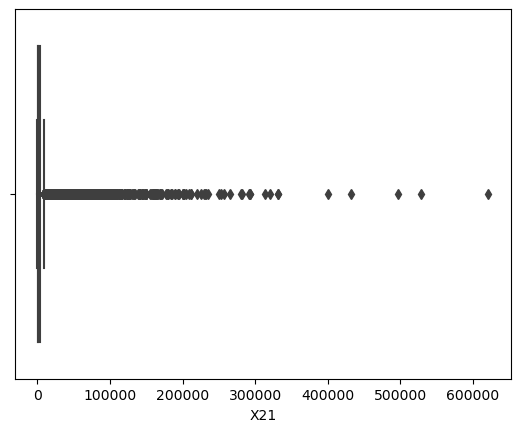

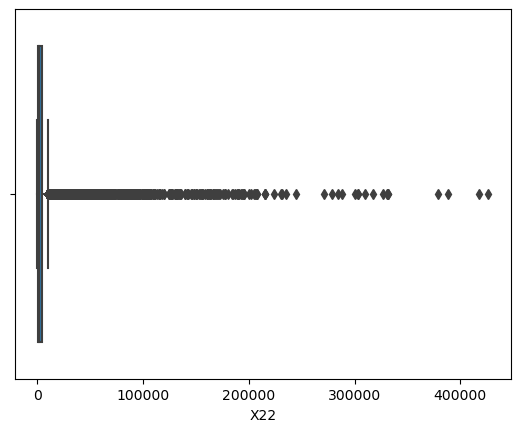

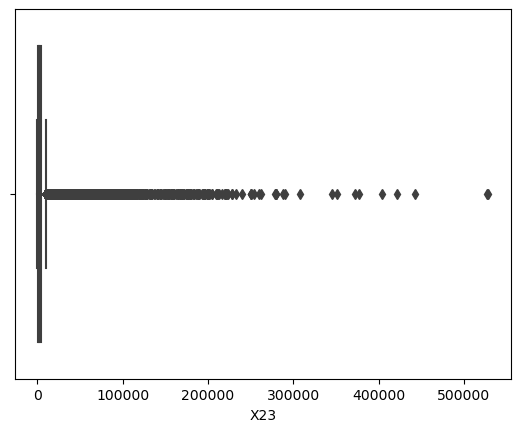

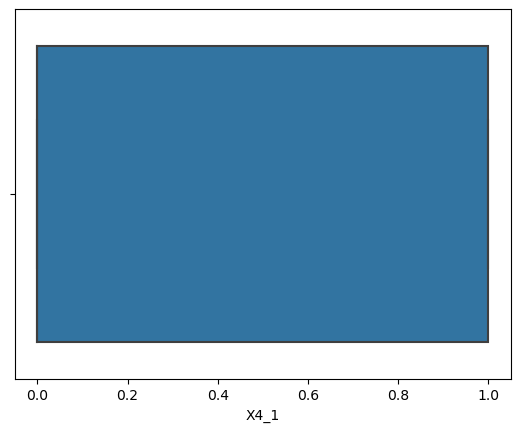

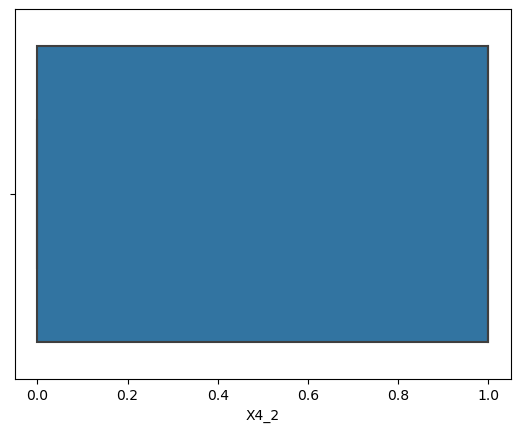

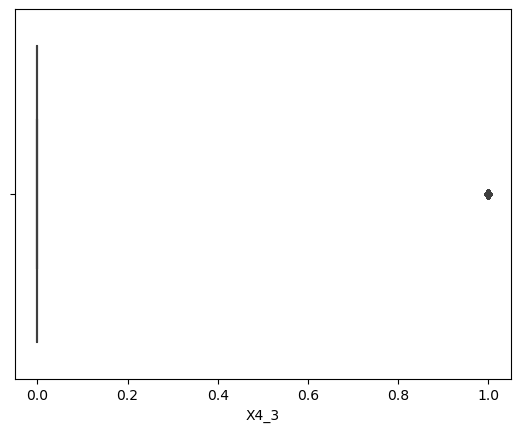

In [11]:
# Box plots for outliers
i = 0
for x in X_df.columns:
    i += 1
    plt.figure(i)
    sns.boxplot(x=X_df[x])
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

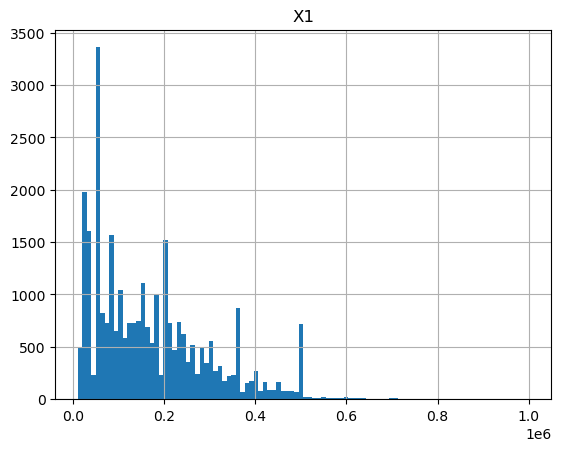

<Figure size 640x480 with 0 Axes>

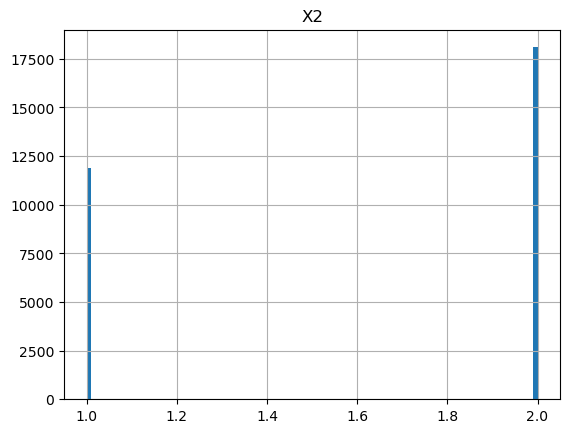

<Figure size 640x480 with 0 Axes>

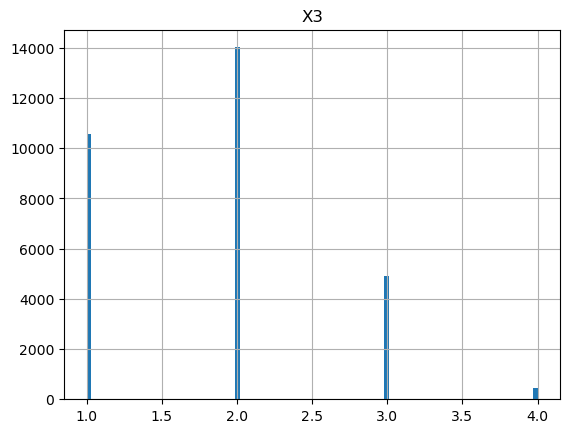

<Figure size 640x480 with 0 Axes>

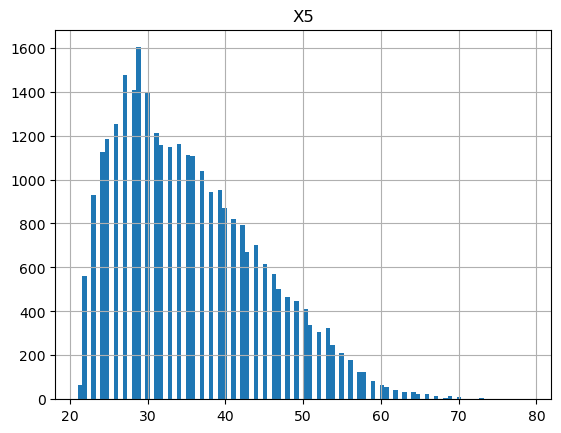

<Figure size 640x480 with 0 Axes>

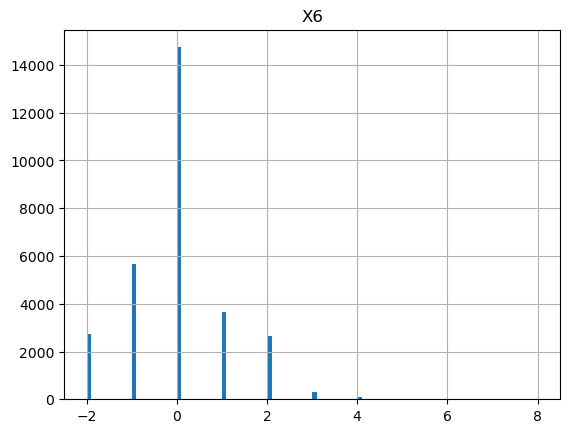

<Figure size 640x480 with 0 Axes>

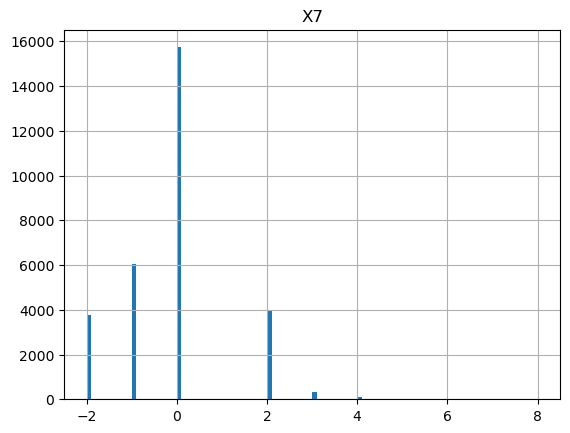

<Figure size 640x480 with 0 Axes>

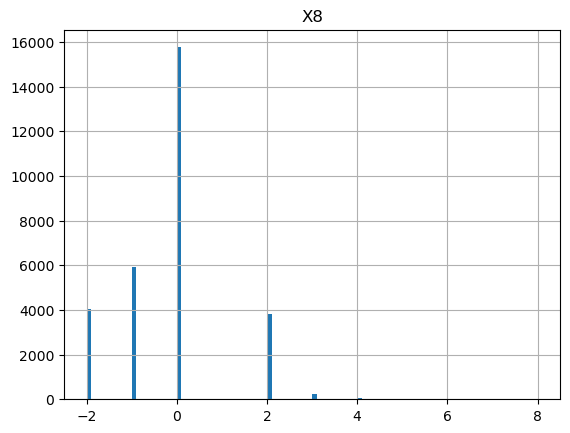

<Figure size 640x480 with 0 Axes>

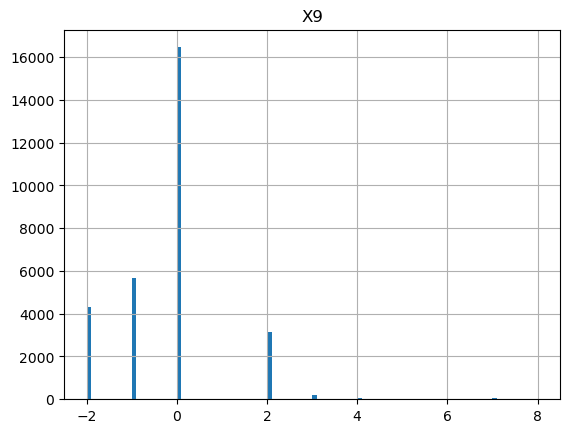

<Figure size 640x480 with 0 Axes>

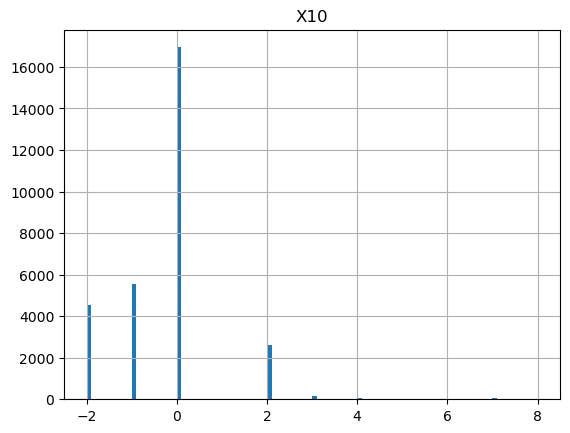

<Figure size 640x480 with 0 Axes>

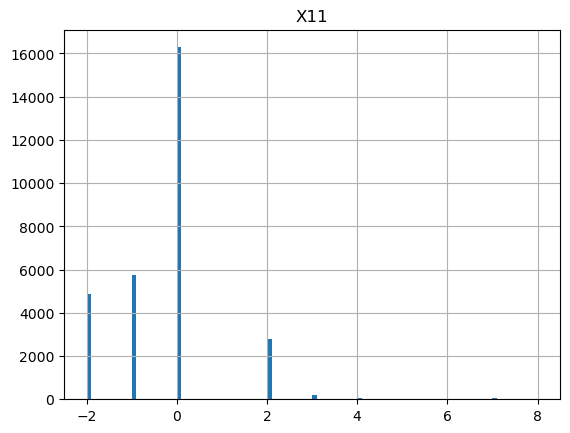

<Figure size 640x480 with 0 Axes>

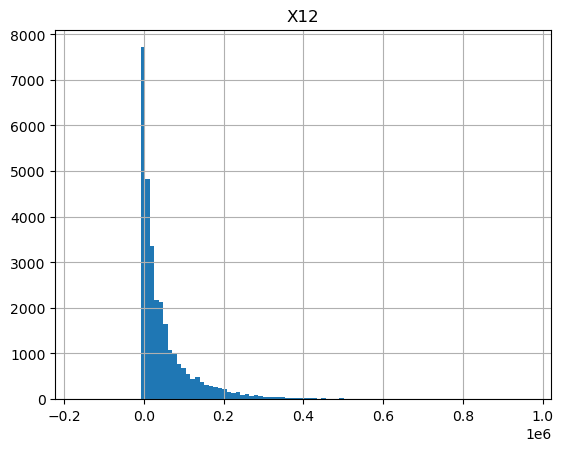

<Figure size 640x480 with 0 Axes>

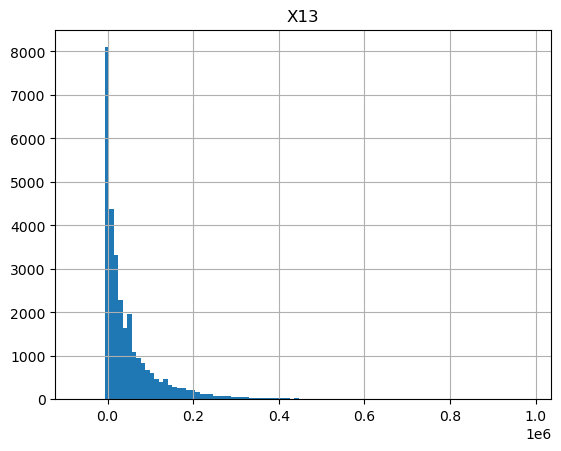

<Figure size 640x480 with 0 Axes>

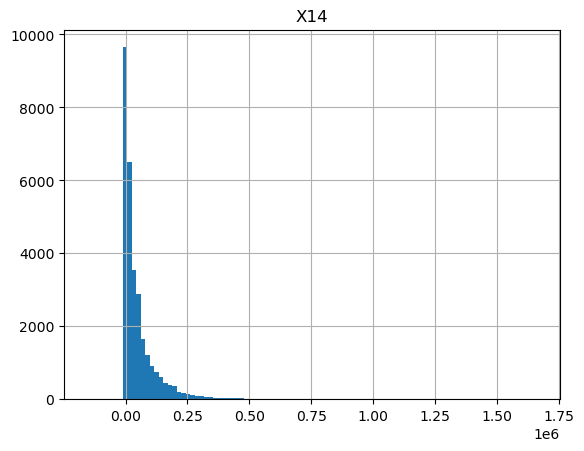

<Figure size 640x480 with 0 Axes>

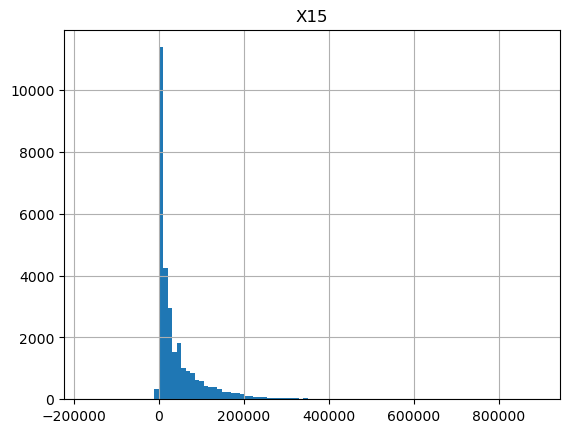

<Figure size 640x480 with 0 Axes>

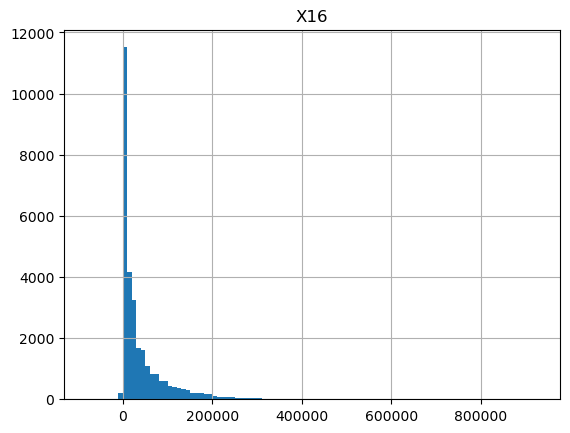

<Figure size 640x480 with 0 Axes>

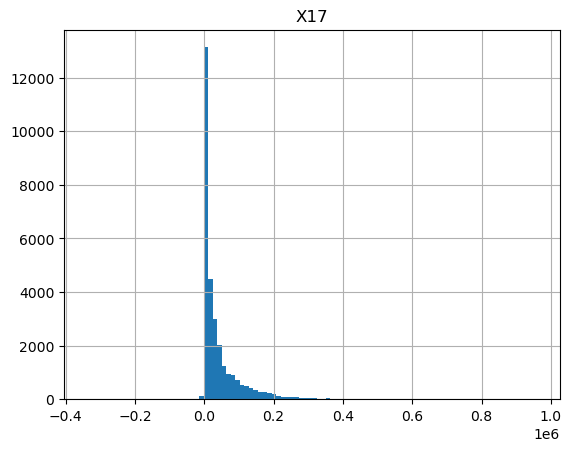

<Figure size 640x480 with 0 Axes>

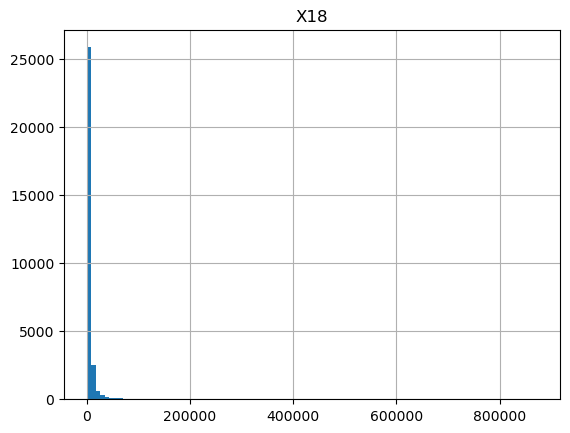

<Figure size 640x480 with 0 Axes>

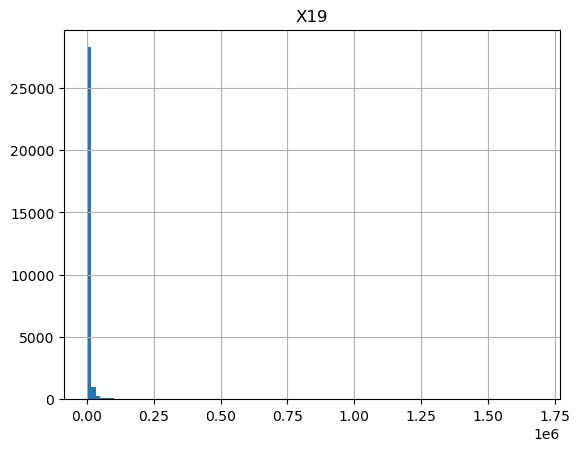

<Figure size 640x480 with 0 Axes>

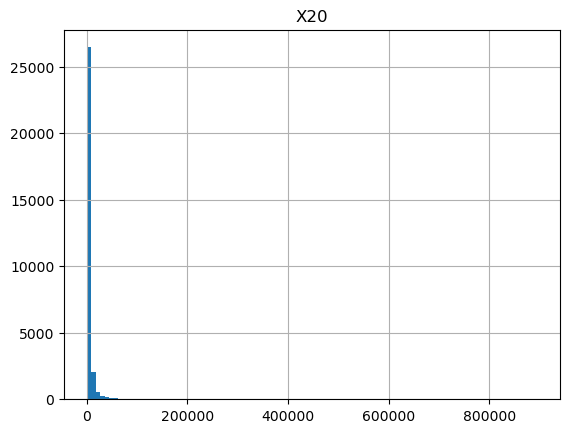

<Figure size 640x480 with 0 Axes>

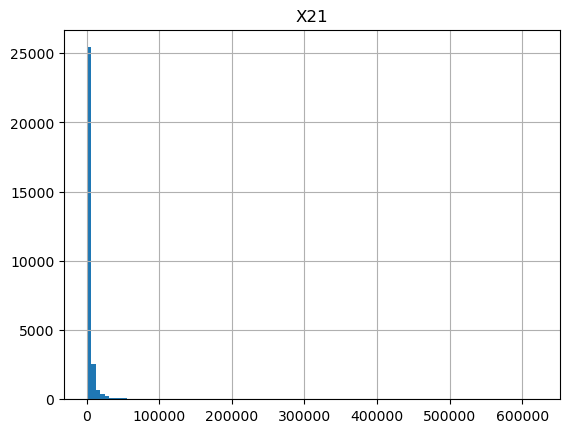

<Figure size 640x480 with 0 Axes>

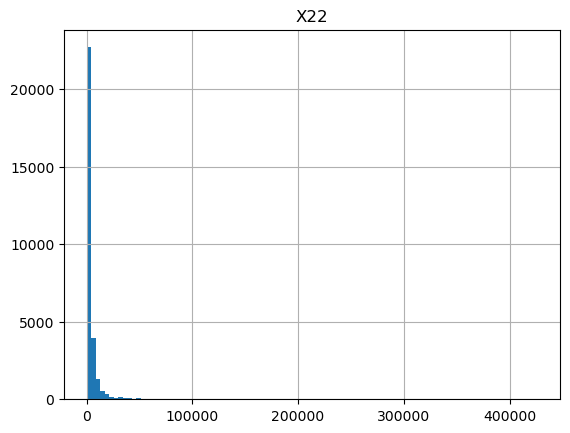

<Figure size 640x480 with 0 Axes>

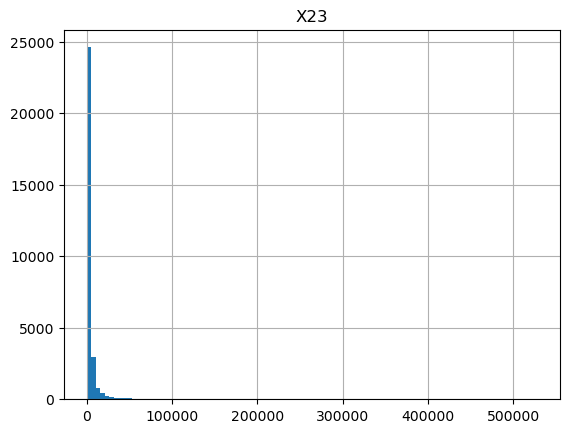

<Figure size 640x480 with 0 Axes>

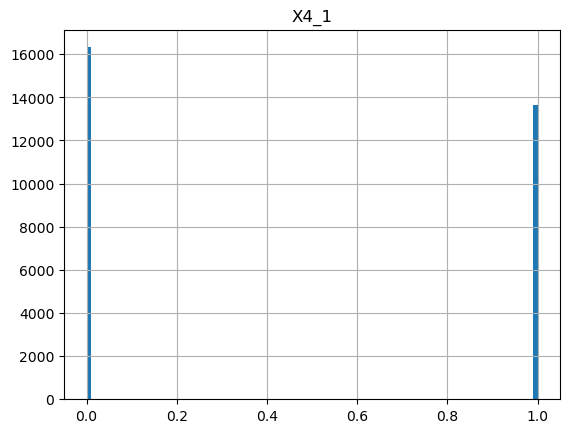

<Figure size 640x480 with 0 Axes>

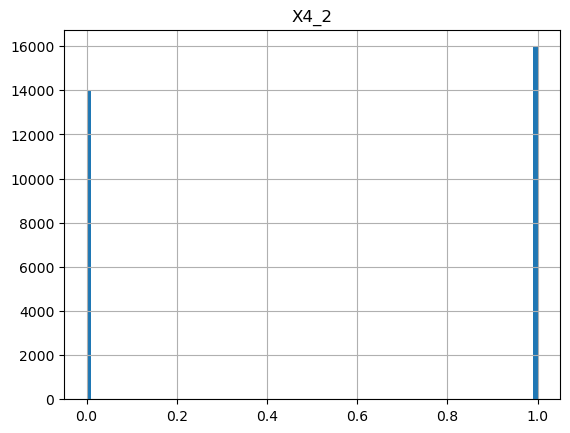

<Figure size 640x480 with 0 Axes>

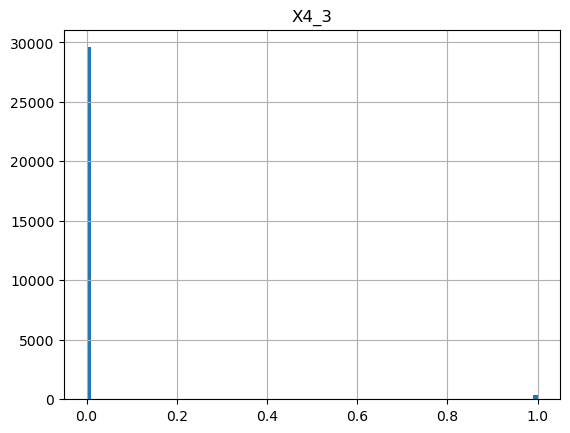

In [12]:
# Histograms
i = 0
for x in X_df.columns:
    i += 1
    plt.figure(i)
    hist = X_df.hist(column=[x], bins=100)
    plt.show()
    plt.close()

In [13]:
seed = 903946366

# Shuffle data and then split into the training and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = seed, 
                                                    stratify = y)

DT train accuracy: 0.8209296781883194
DT test accuracy: 0.8203559510567296
DT train f1 score: 0.44306049822064053
DT test f1 score: 0.4417559626685102
DT train roc_auc: 0.7323612070026984
DT test roc_auc: 0.7372104925899763


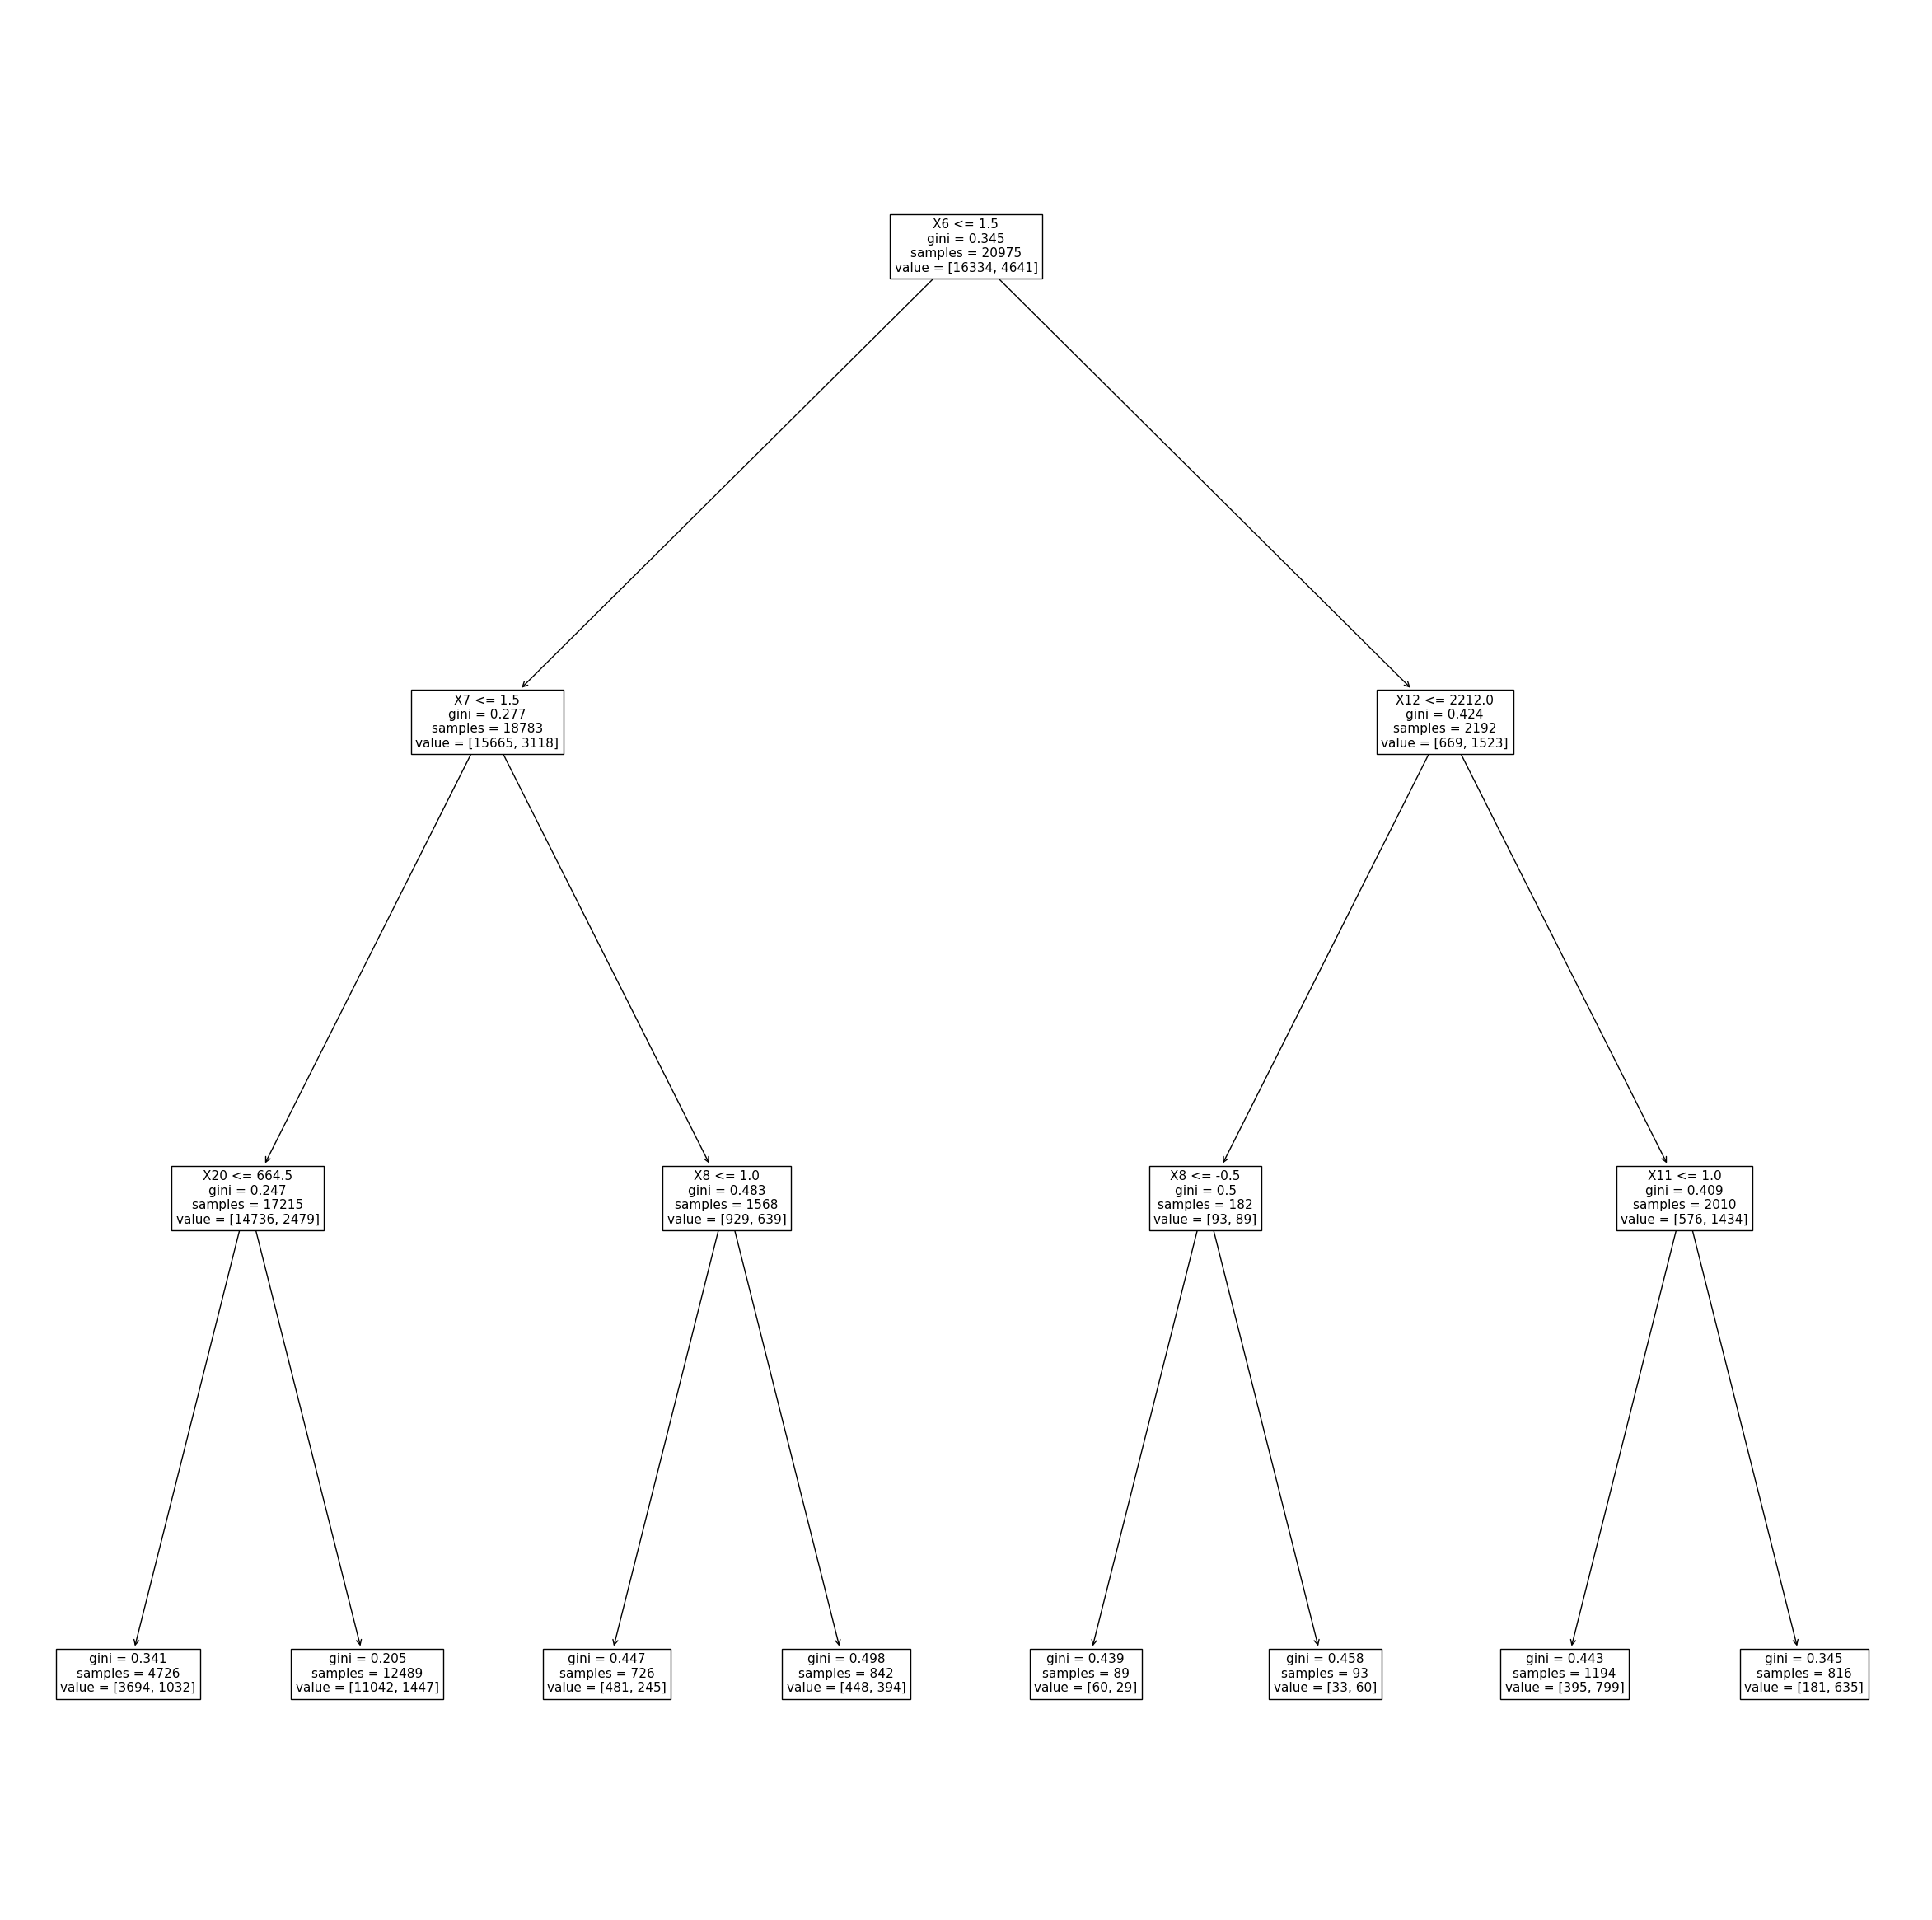

In [14]:
# Decision tree classifier

clf = DecisionTreeClassifier(max_depth=3, random_state=seed)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

dt_train_acc = accuracy_score(y_train, y_pred_train)
dt_test_acc = accuracy_score(y_test, y_pred_test)

dt_train_f1 = f1_score(y_train, y_pred_train)
dt_test_f1 = f1_score(y_test, y_pred_test)

dt_train_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
dt_test_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f'DT train accuracy: {dt_train_acc}')    
print(f'DT test accuracy: {dt_test_acc}')

print(f'DT train f1 score: {dt_train_f1}')    
print(f'DT test f1 score: {dt_test_f1}') 

print(f'DT train roc_auc: {dt_train_roc_auc}')    
print(f'DT test roc_auc: {dt_test_roc_auc}') 

fig = plt.figure(figsize=(30,30))
plot_tree(clf, feature_names = list(X_df.columns), fontsize=11)
plt.show()
fig.savefig('DT-max_depth-3.png')
plt.close(fig)

In [15]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# stopped here

1. KNN

In [15]:
# KNN
# ===============================
# 3) K nearest neighbors learner
# ===============================

# A) Validation curves for k using uniform weights

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

k_list = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]+list(range(40,1040,40))

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2) 
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                            n_jobs=8)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('KNN cross-validation for #neighbors using uniform weights and Euclidean distance')
print(f'Maximum accuracy score: {max(test_acc_m)} at k={k_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum roc_auc score: {max(test_roc_m)} at k={k_list[test_roc_m.index(max(test_roc_m))]}')

train_acc_m_knn1 = np.asarray(train_acc_m)
train_acc_std_knn1 = np.asarray(train_acc_std)
test_acc_m_knn1 = np.asarray(test_acc_m)
test_acc_std_knn1 = np.asarray(test_acc_std) 

train_roc_m_knn1 = np.asarray(train_roc_m)
train_roc_std_knn1 = np.asarray(train_roc_std)
test_roc_m_knn1 = np.asarray(test_roc_m)
test_roc_std_knn1 = np.asarray(test_roc_std)

KNN cross-validation for #neighbors using uniform weights and Euclidean distance
Maximum accuracy score: 0.8077234803337306 at k=40
Maximum roc_auc score: 0.7520349883598632 at k=1000


In [16]:
# KNN
# ===============================
# 3) K nearest neighbors learner
# ===============================

# B) Validation curves for k using weighted distance

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

k_list = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]+list(range(40,1040,40))

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2) 
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                            n_jobs=8)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('KNN cross-validation for #neighbors using weights by the Euclidean distance')
print(f'Maximum accuracy score: {max(test_acc_m)} at k={k_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum roc_auc score: {max(test_roc_m)} at k={k_list[test_roc_m.index(max(test_roc_m))]}')

train_acc_m_knn2 = np.asarray(train_acc_m)
train_acc_std_knn2 = np.asarray(train_acc_std)
test_acc_m_knn2 = np.asarray(test_acc_m)
test_acc_std_knn2 = np.asarray(test_acc_std) 

train_roc_m_knn2 = np.asarray(train_roc_m)
train_roc_std_knn2 = np.asarray(train_roc_std)
test_roc_m_knn2 = np.asarray(test_roc_m)
test_roc_std_knn2 = np.asarray(test_roc_std)

KNN cross-validation for #neighbors using weights by the Euclidean distance
Maximum accuracy score: 0.807532777115614 at k=40
Maximum roc_auc score: 0.7528686622592862 at k=1000


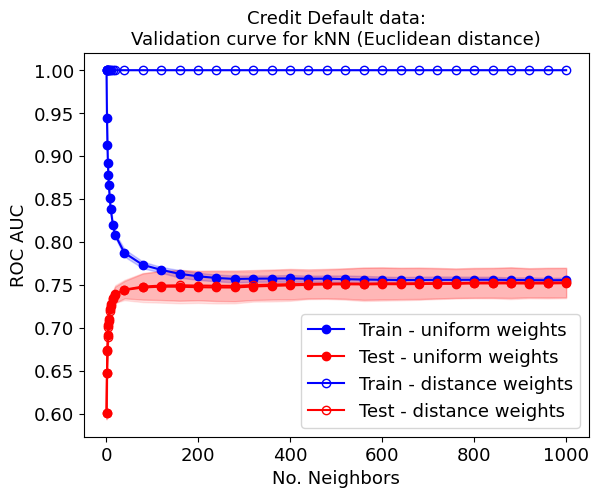

In [17]:
fontsize = 13

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# Uniform weights
ax.plot(k_list, train_roc_m_knn1, 'o-', color='b', label='Train - uniform weights')
ax.fill_between(k_list, train_roc_m_knn1 - 2*train_roc_std_knn1, train_roc_m_knn1 + 2*train_roc_std_knn1, 
                alpha=0.2, color="b")

ax.plot(k_list, test_roc_m_knn1, 'o-', color='r', label='Test - uniform weights')
ax.fill_between(k_list, test_roc_m_knn1 - 2*test_roc_std_knn1, test_roc_m_knn1 + 2*test_roc_std_knn1, 
                alpha=0.1, color="r")

# Distance weights
ax.plot(k_list, train_roc_m_knn2, 'o-', color='b', markerfacecolor='none', label='Train - distance weights')
ax.fill_between(k_list, train_roc_m_knn2 - 2*train_roc_std_knn2, train_roc_m_knn2 + 2*train_roc_std_knn2, 
                alpha=0.1, color="b")

ax.plot(k_list, test_roc_m_knn2, 'o-', color='r', markerfacecolor='none', label='Test - distance weights')
ax.fill_between(k_list, test_roc_m_knn2 - 2*test_roc_std_knn2, test_roc_m_knn2 + 2*test_roc_std_knn2, 
                alpha=0.2, color="r")

ax.legend(fontsize=fontsize, loc="best")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data:\nValidation curve for kNN (Euclidean distance)', fontsize=fontsize) 
ax.set_xlabel('No. Neighbors', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
plt.show()
fig.savefig('knn-roc_auc-neighbors-euclidean.png')
plt.close(fig)

In [24]:
# KNN
# ===============================
# 3) K nearest neighbors learner
# ===============================

# C) Validation curves for k using uniform weights and the Manhattan distance

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

k_list = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25]+list(range(50,650,50))

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1) 
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                            n_jobs=8)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('KNN cross-validation for #neighbors using uniform weights and the Manhattan distance')
print(f'Maximum accuracy score: {max(test_acc_m)} at k={k_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum roc_auc score: {max(test_roc_m)} at k={k_list[test_roc_m.index(max(test_roc_m))]}')

train_acc_m_knn3 = np.asarray(train_acc_m)
train_acc_std_knn3 = np.asarray(train_acc_std)
test_acc_m_knn3 = np.asarray(test_acc_m)
test_acc_std_knn3 = np.asarray(test_acc_std) 

train_roc_m_knn3 = np.asarray(train_roc_m)
train_roc_std_knn3 = np.asarray(train_roc_std)
test_roc_m_knn3 = np.asarray(test_roc_m)
test_roc_std_knn3 = np.asarray(test_roc_std)

KNN cross-validation for #neighbors using uniform weights and the Manhattan distance
Maximum accuracy score: 0.8061025029797377 at k=50
Maximum roc_auc score: 0.754131941621712 at k=600


In [25]:
# KNN
# ===============================
# 3) K nearest neighbors learner
# ===============================

# D) Validation curves for k using weights by the Manhattan distance

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

k_list = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25]+list(range(50,650,50))

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=1) 
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                            n_jobs=8)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('KNN cross-validation for #neighbors using weights by Manhattan')
print(f'Maximum accuracy score: {max(test_acc_m)} at k={k_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum roc_auc score: {max(test_roc_m)} at k={k_list[test_roc_m.index(max(test_roc_m))]}')

train_acc_m_knn4 = np.asarray(train_acc_m)
train_acc_std_knn4 = np.asarray(train_acc_std)
test_acc_m_knn4 = np.asarray(test_acc_m)
test_acc_std_knn4 = np.asarray(test_acc_std) 

train_roc_m_knn4 = np.asarray(train_roc_m)
train_roc_std_knn4 = np.asarray(train_roc_std)
test_roc_m_knn4 = np.asarray(test_roc_m)
test_roc_std_knn4 = np.asarray(test_roc_std)

KNN cross-validation for #neighbors using weights by Manhattan
Maximum accuracy score: 0.805864123957092 at k=25
Maximum roc_auc score: 0.7547533901134952 at k=600


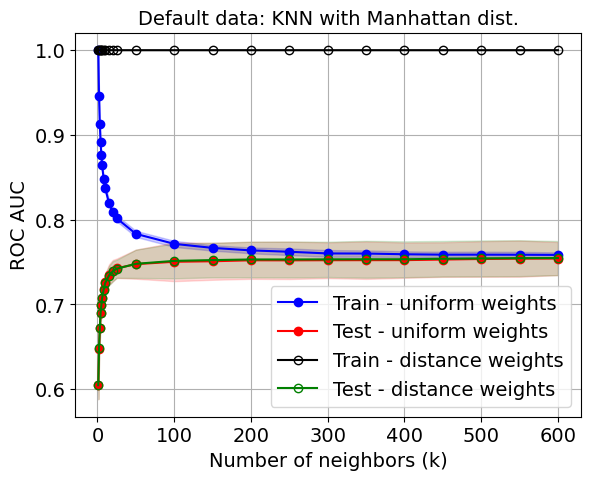

In [111]:
fontsize = 14

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# Uniform weights
ax.plot(k_list, train_roc_m_knn3, 'o-', color='b', label='Train - uniform weights')
ax.fill_between(k_list, train_roc_m_knn3 - 2*train_roc_std_knn3, train_roc_m_knn3 + 2*train_roc_std_knn3, 
                alpha=0.2, color="b")

ax.plot(k_list, test_roc_m_knn3, 'o-', color='r', label='Test - uniform weights')
ax.fill_between(k_list, test_roc_m_knn3 - 2*test_roc_std_knn3, test_roc_m_knn3 + 2*test_roc_std_knn3, 
                alpha=0.15, color="r")

# Distance weights
ax.plot(k_list, train_roc_m_knn4, 'o-', color='k', markerfacecolor='none', label='Train - distance weights')
ax.fill_between(k_list, train_roc_m_knn4 - 2*train_roc_std_knn4, train_roc_m_knn4 + 2*train_roc_std_knn4, 
                alpha=0.1, color="k")

ax.plot(k_list, test_roc_m_knn4, 'o-', color='g', markerfacecolor='none', label='Test - distance weights')
ax.fill_between(k_list, test_roc_m_knn4 - 2*test_roc_std_knn4, test_roc_m_knn4 + 2*test_roc_std_knn4, 
                alpha=0.15, color="g")

ax.legend(fontsize=fontsize, loc="best")
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: KNN with Manhattan dist.', fontsize=fontsize) 
ax.set_xlabel('Number of neighbors (k)', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
plt.grid(True)
plt.show()
fig.savefig('knn-roc_auc-neighbors-manhattan.png')
plt.close(fig)

In [28]:
test_roc_m_knn4

array([0.60476254, 0.64821686, 0.67241667, 0.68948919, 0.69880241,
       0.70714285, 0.71742078, 0.72518284, 0.73406017, 0.73920318,
       0.74214203, 0.74796461, 0.75140945, 0.75234991, 0.75308206,
       0.75307284, 0.75323435, 0.75334362, 0.75333862, 0.75392746,
       0.75433074, 0.754612  , 0.75475339])

In [29]:
test_acc_m

[0.7240047675804528,
 0.7242431466030989,
 0.7657210965435042,
 0.7689630512514898,
 0.7834564958283672,
 0.7844100119189511,
 0.7943742550655543,
 0.7987127532777116,
 0.8030035756853398,
 0.8040524433849822,
 0.805864123957092,
 0.8055780691299166,
 0.8046245530393324,
 0.8041477949940405,
 0.804004767580453,
 0.8028605482717521,
 0.8020500595947556,
 0.8017163289630513,
 0.8009535160905841,
 0.8,
 0.7998569725864124,
 0.8001430274135876,
 0.7994755661501788]

2. SVM

In [116]:
# ===============================
# 2) SVM learner
# ===============================

# A) Validation curves for the kernel type

dmax = 8
poly_list = []
for d in range(2, dmax+1):
    poly_list.append('poly'+str(d))
    
kernel_list = ['linear'] + poly_list + ['rbf', 'sigmoid']
    
train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []
    

for kernel in kernel_list:
    print(f'SVM cross validation with {kernel} kernel')
    if kernel[0:4] == 'poly':
        clf = svm.SVC(kernel='poly', gamma='scale', degree = int(kernel[-1]), random_state=seed) # default gamma
    else:
        clf = svm.SVC(kernel=kernel, gamma='scale', random_state=seed) # default gamma

    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True,
                            n_jobs=8)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))
    
print('SVM cross-validation')
print(f'Maximum accuracy score: {max(test_acc_m)} at kernel={kernel_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum roc_auc score: {max(test_roc_m)} at kernel={kernel_list[test_roc_m.index(max(test_roc_m))]}')
    
train_acc_m_svm = np.asarray(train_acc_m)
train_acc_std_svm = np.asarray(train_acc_std)
test_acc_m_svm = np.asarray(test_acc_m)
test_acc_std_svm = np.asarray(test_acc_std) 

train_roc_m_svm = np.asarray(train_roc_m)
train_roc_std_svm = np.asarray(train_roc_std)
test_roc_m_svm = np.asarray(test_roc_m)
test_roc_std_svm = np.asarray(test_roc_std)

SVM cross validation with linear kernel
SVM cross validation with poly2 kernel
SVM cross validation with poly3 kernel
SVM cross validation with poly4 kernel
SVM cross validation with poly5 kernel
SVM cross validation with poly6 kernel
SVM cross validation with poly7 kernel
SVM cross validation with poly8 kernel
SVM cross validation with rbf kernel
SVM cross validation with sigmoid kernel
SVM cross-validation
Maximum accuracy score: 0.8174970202622169 at kernel=rbf
Maximum roc_auc score: 0.7162348600953409 at kernel=rbf


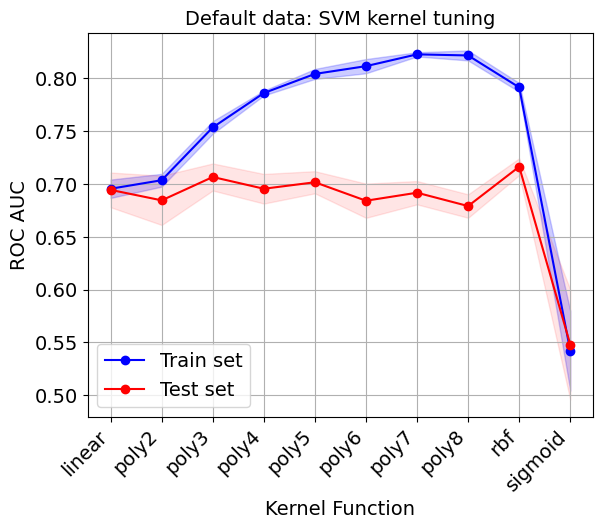

In [119]:
fontsize = 14
# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# svn
ax.plot(kernel_list, train_roc_m_svm, 'o-', color='b', label='Train set')
ax.fill_between(kernel_list, train_roc_m_svm - 2*train_roc_std_svm, train_roc_m_svm + 2*train_roc_std_svm, 
                alpha=0.2, color="b")

ax.plot(kernel_list, test_roc_m_svm, 'o-', color='r', label='Test set')
ax.fill_between(kernel_list, test_roc_m_svm - 2*test_roc_std_svm, test_roc_m_svm + 2*test_roc_std_svm, 
                alpha=0.1, color="r")

ax.legend(fontsize=fontsize, loc="best")
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: SVM kernel tuning', fontsize=fontsize) 
ax.set_xlabel('Kernel Function', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()
fig.savefig('svm-roc_auc-kernel.png')
plt.close(fig)

In [118]:
# -------------------------------
# Validation curve for the regularization parameter with a rbf kernel

C_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0, 5.0, 10.0, 20, 50, 100.0, 500, 1000.0, 5000.0, 10000.0]

C_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]

kernel = 'rbf'

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

for C in C_list:
    print(C)
    clf = svm.SVC(kernel=kernel, gamma='scale', C=C, random_state=seed)
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy', 'roc_auc'], return_train_score=True)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('SVM rbf: regularization parameter')
print(f'Maximum accuracy score: {max(test_acc_m)} at C={C_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum validation score: {max(test_roc_m)} at C={C_list[test_roc_m.index(max(test_roc_m))]}')    

train_acc_m_svm1 = np.asarray(train_acc_m)
train_acc_std_svm1 = np.asarray(train_acc_std)
test_acc_m_svm1 = np.asarray(test_acc_m)
test_acc_std_svm1 = np.asarray(test_acc_std) 

train_roc_m_svm1 = np.asarray(train_roc_m)
train_roc_std_svm1 = np.asarray(train_roc_std)
test_roc_m_svm1 = np.asarray(test_roc_m)
test_roc_std_svm1 = np.asarray(test_roc_std)

kernel = 'poly'

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

for C in C_list:
    print(C)
    clf = svm.SVC(kernel=kernel, gamma='scale', C=C, degree = 3, random_state=seed)
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy', 'roc_auc'], return_train_score=True)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('SVM linear: regularization parameter')
print(f'Maximum accuracy score: {max(test_acc_m)} at C={C_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum validation score: {max(test_roc_m)} at C={C_list[test_roc_m.index(max(test_roc_m))]}')    

train_acc_m_svm2 = np.asarray(train_acc_m)
train_acc_std_svm2 = np.asarray(train_acc_std)
test_acc_m_svm2 = np.asarray(test_acc_m)
test_acc_std_svm2 = np.asarray(test_acc_std) 

train_roc_m_svm2 = np.asarray(train_roc_m)
train_roc_std_svm2 = np.asarray(train_roc_std)
test_roc_m_svm2 = np.asarray(test_roc_m)
test_roc_std_svm2 = np.asarray(test_roc_std)



1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0


KeyboardInterrupt: 

In [39]:
test_acc_m_svm1

array([0.77873659, 0.77873659, 0.77873659, 0.77873659, 0.78898689,
       0.81330155, 0.81749702, 0.81535161, 0.79742551, 0.7749702 ])

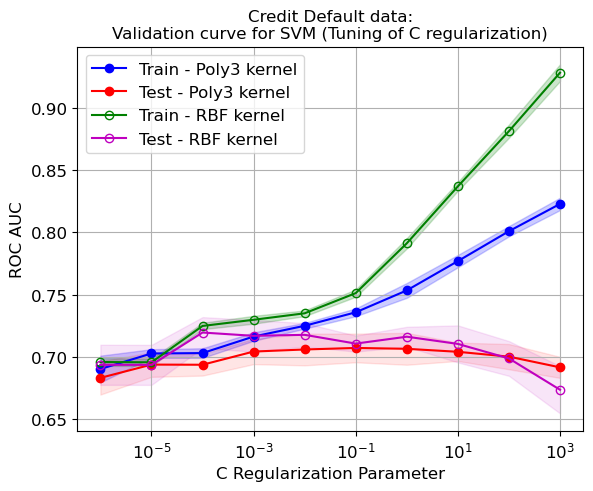

In [31]:
fontsize = 12

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# Poly3
ax.plot(C_list, train_roc_m_svm2, 'o-', color='b', label='Train - Poly3 kernel')
ax.fill_between(C_list, train_roc_m_svm2 - 2*train_roc_std_svm2, train_roc_m_svm2 + 2*train_roc_std_svm2, 
                alpha=0.2, color="b")

ax.plot(C_list, test_roc_m_svm2, 'o-', color='r', label='Test - Poly3 kernel')
ax.fill_between(C_list, test_roc_m_svm2 - 2*test_roc_std_svm2, test_roc_m_svm2 + 2*test_roc_std_svm2, 
                alpha=0.1, color="r")

# RBF kernel
ax.plot(C_list, train_roc_m_svm1, 'o-', color='g', markerfacecolor='none', label='Train - RBF kernel')
ax.fill_between(C_list, train_roc_m_svm1 - 2*train_roc_std_svm1, train_roc_m_svm1 + 2*train_roc_std_svm1, 
                alpha=0.2, color="g")

ax.plot(C_list, test_roc_m_svm1, 'o-', color='m', markerfacecolor='none', label='Test - RBF kernel')
ax.fill_between(C_list, test_roc_m_svm1 - 2*test_roc_std_svm1, test_roc_m_svm1 + 2*test_roc_std_svm1, 
                alpha=0.1, color="m")

ax.set_xscale("log", base=10)
ax.legend(fontsize=fontsize, loc="upper left")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data:\nValidation curve for SVM (Tuning of C regularization)', fontsize=fontsize) 
ax.set_xlabel('C Regularization Parameter', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize)
plt.grid(True)
plt.show()
fig.savefig('svm-roc_auc-C.png')
plt.close(fig)

In [ ]:
kernel = 'poly'

train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

for C in C_list:
    print(C)
    clf = svm.SVC(kernel=kernel, gamma='scale', C=C, degree = 8, random_state=seed)
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy', 'roc_auc'], return_train_score=True)
    
    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

print('SVM linear: regularization parameter')
print(f'Maximum accuracy score: {max(test_acc_m)} at C={C_list[test_acc_m.index(max(test_acc_m))]}')
print(f'Maximum validation score: {max(test_roc_m)} at C={C_list[test_roc_m.index(max(test_roc_m))]}')    

train_acc_m_svm8 = np.asarray(train_acc_m)
train_acc_std_svm8 = np.asarray(train_acc_std)
test_acc_m_svm8 = np.asarray(test_acc_m)
test_acc_std_svm8 = np.asarray(test_acc_std) 

train_roc_m_svm8 = np.asarray(train_roc_m)
train_roc_std_svm8 = np.asarray(train_roc_std)
test_roc_m_svm8 = np.asarray(test_roc_m)
test_roc_std_svm8 = np.asarray(test_roc_std)

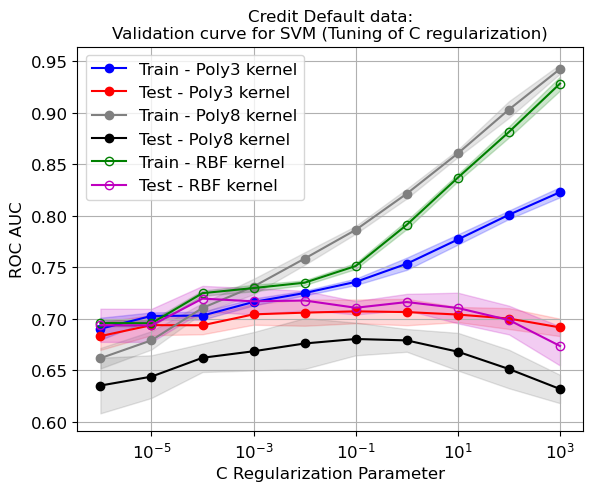

In [37]:


fontsize = 12

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# Poly3
ax.plot(C_list, train_roc_m_svm2, 'o-', color='b', label='Train - Poly3 kernel')
ax.fill_between(C_list, train_roc_m_svm2 - 2*train_roc_std_svm2, train_roc_m_svm2 + 2*train_roc_std_svm2, 
                alpha=0.2, color="b")

ax.plot(C_list, test_roc_m_svm2, 'o-', color='r', label='Test - Poly3 kernel')
ax.fill_between(C_list, test_roc_m_svm2 - 2*test_roc_std_svm2, test_roc_m_svm2 + 2*test_roc_std_svm2, 
                alpha=0.15, color="r")

# Poly8
grey = (1/2.0, 1/2.0, 1/2.0)
ax.plot(C_list, train_roc_m_svm8, 'o-', color=grey, label='Train - Poly8 kernel')
ax.fill_between(C_list, train_roc_m_svm8 - 2*train_roc_std_svm8, train_roc_m_svm8 + 2*train_roc_std_svm8, 
                alpha=0.2, color=grey)

ax.plot(C_list, test_roc_m_svm8, 'o-', color='k', label='Test - Poly8 kernel')
ax.fill_between(C_list, test_roc_m_svm8 - 2*test_roc_std_svm8, test_roc_m_svm8 + 2*test_roc_std_svm8, 
                alpha=0.1, color="k")

# RBF kernel
ax.plot(C_list, train_roc_m_svm1, 'o-', color='g', markerfacecolor='none', label='Train - RBF kernel')
ax.fill_between(C_list, train_roc_m_svm1 - 2*train_roc_std_svm1, train_roc_m_svm1 + 2*train_roc_std_svm1, 
                alpha=0.2, color="g")

ax.plot(C_list, test_roc_m_svm1, 'o-', color='m', markerfacecolor='none', label='Test - RBF kernel')
ax.fill_between(C_list, test_roc_m_svm1 - 2*test_roc_std_svm1, test_roc_m_svm1 + 2*test_roc_std_svm1, 
                alpha=0.2, color="m")

ax.set_xscale("log", base=10)
ax.legend(fontsize=fontsize, loc="upper left")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data:\nValidation curve for SVM (Tuning of C regularization)', fontsize=fontsize) 
ax.set_xlabel('C Regularization Parameter', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize)
plt.grid(True)
plt.show()

fig.savefig('svm-roc_auc-C_poly8-vs-rbf.png')
plt.close(fig)

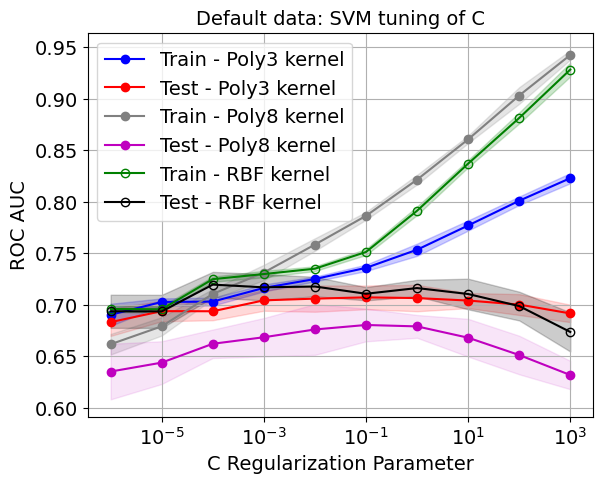

In [123]:
fontsize = 14

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
# Poly3
ax.plot(C_list, train_roc_m_svm2, 'o-', color='b', label='Train - Poly3 kernel')
ax.fill_between(C_list, train_roc_m_svm2 - 2*train_roc_std_svm2, train_roc_m_svm2 + 2*train_roc_std_svm2, 
                alpha=0.2, color="b")

ax.plot(C_list, test_roc_m_svm2, 'o-', color='r', label='Test - Poly3 kernel')
ax.fill_between(C_list, test_roc_m_svm2 - 2*test_roc_std_svm2, test_roc_m_svm2 + 2*test_roc_std_svm2, 
                alpha=0.15, color="r")

# Poly8
grey = (1/2.0, 1/2.0, 1/2.0)
ax.plot(C_list, train_roc_m_svm8, 'o-', color=grey, label='Train - Poly8 kernel')
ax.fill_between(C_list, train_roc_m_svm8 - 2*train_roc_std_svm8, train_roc_m_svm8 + 2*train_roc_std_svm8, 
                alpha=0.2, color=grey)

ax.plot(C_list, test_roc_m_svm8, 'o-', color='m', label='Test - Poly8 kernel')
ax.fill_between(C_list, test_roc_m_svm8 - 2*test_roc_std_svm8, test_roc_m_svm8 + 2*test_roc_std_svm8, 
                alpha=0.1, color="m")

# RBF kernel
ax.plot(C_list, train_roc_m_svm1, 'o-', color='g', markerfacecolor='none', label='Train - RBF kernel')
ax.fill_between(C_list, train_roc_m_svm1 - 2*train_roc_std_svm1, train_roc_m_svm1 + 2*train_roc_std_svm1, 
                alpha=0.2, color="g")

ax.plot(C_list, test_roc_m_svm1, 'o-', color='k', markerfacecolor='none', label='Test - RBF kernel')
ax.fill_between(C_list, test_roc_m_svm1 - 2*test_roc_std_svm1, test_roc_m_svm1 + 2*test_roc_std_svm1, 
                alpha=0.2, color="k")

ax.set_xscale("log", base=10)
ax.legend(fontsize=fontsize, loc="upper left")
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: SVM tuning of C', fontsize=fontsize) 
ax.set_xlabel('C Regularization Parameter', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize)
plt.grid(True)
plt.show()

fig.savefig('svm-roc_auc-C_poly8-vs-rbf-temp.png')
plt.close(fig)

3. Neural Network learner

relu
MLP with 1 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 1 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7695611314873032 at 3 nodes
Maximum accuracy score: 0.818927294398093 at 1 nodes
MLP with 2 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 2 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7684663885253409 at 6 nodes
Maximum accuracy score: 0.8188796185935636 at 5 nodes


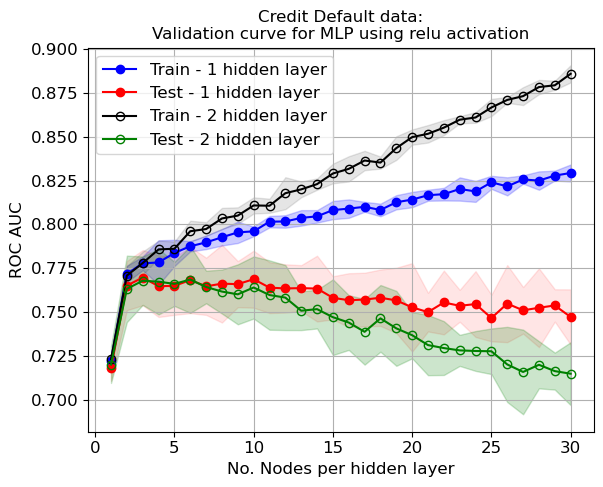

In [20]:
# ====================================
# Repeat with lbfgs solver
# ====================================

#----------------------------------------------------
# A) Hidden layers and nodes per layer
#----------------------------------------------------

activation_list = ['relu']

for activation in activation_list:
    
    print(activation)
    
    ########################
    ## 1 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []

    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    hidden_layers = 1
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp1r = np.asarray(train_acc_m)
    train_acc_std_mlp1r = np.asarray(train_acc_std)
    test_acc_m_mlp1r = np.asarray(test_acc_m)
    test_acc_std_mlp1r = np.asarray(test_acc_std) 
    
    train_roc_m_mlp1r = np.asarray(train_roc_m)
    train_roc_std_mlp1r = np.asarray(train_roc_std)
    test_roc_m_mlp1r = np.asarray(test_roc_m)
    test_roc_std_mlp1r = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    ########################
    ## 2 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []
    
    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    learning_rate_init=0.001
    hidden_layers = 2
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp2r = np.asarray(train_acc_m)
    train_acc_std_mlp2r = np.asarray(train_acc_std)
    test_acc_m_mlp2r = np.asarray(test_acc_m)
    test_acc_std_mlp2r = np.asarray(test_acc_std) 
    
    train_roc_m_mlp2r = np.asarray(train_roc_m)
    train_roc_std_mlp2r = np.asarray(train_roc_std)
    test_roc_m_mlp2r = np.asarray(test_roc_m)
    test_roc_std_mlp2r = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    fontsize = 14

    # roc_auc
    fig = plt.figure()
    ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
    # Uniform weights
    ax.plot(nodes_list, train_roc_m_mlp1r, 'o-', color='b', label='Train - 1 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp1r - 2*train_roc_std_mlp1r, train_roc_m_mlp1r + 2*train_roc_std_mlp1r, 
                    alpha=0.2, color="b")
    
    ax.plot(nodes_list, test_roc_m_mlp1r, 'o-', color='r', label='Test - 1 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp1r - 2*test_roc_std_mlp1r, test_roc_m_mlp1r + 2*test_roc_std_mlp1r, 
                    alpha=0.1, color="r")
    
    # Distance weights
    ax.plot(nodes_list, train_roc_m_mlp2r, 'o-', color='k', markerfacecolor='none', label='Train - 2 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp2r - 2*train_roc_std_mlp2r, train_roc_m_mlp2r + 2*train_roc_std_mlp2r, 
                    alpha=0.1, color="k")
    
    ax.plot(nodes_list, test_roc_m_mlp2r, 'o-', color='g', markerfacecolor='none', label='Test - 2 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp2r - 2*test_roc_std_mlp2r, test_roc_m_mlp2r + 2*test_roc_std_mlp2r, 
                    alpha=0.2, color="g")
    
    ax.legend(fontsize=fontsize, loc="best")
    ax.tick_params(labelsize=fontsize)
    ax.set_title(f'Default data: MLP using {activation} activation', fontsize=fontsize) 
    ax.set_xlabel('No. Nodes per hidden layer', fontsize=fontsize) 
    ax.set_ylabel('ROC AUC', fontsize=fontsize) 
    #ax.set_ylim(0.955, 0.96)
#    ax.set_xticks(list(range(0,22,2)))
    plt.grid(True)
    plt.show()
    fig.savefig(f'mlp-roc_auc-nodes-{activation}.png')
    plt.close(fig)
    

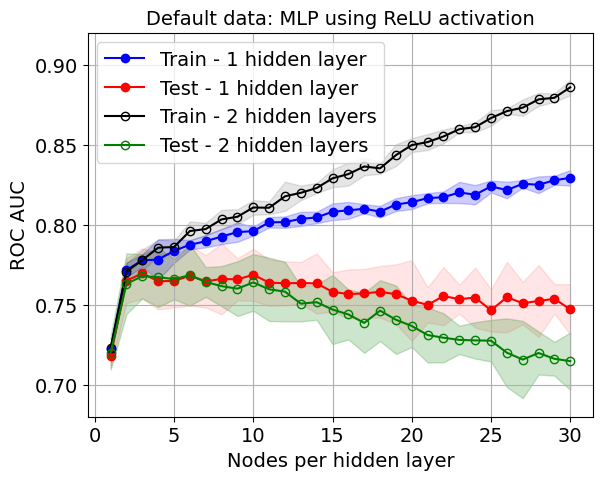

In [127]:
 fontsize = 14

 # roc_auc
 fig = plt.figure()
 ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
 # Uniform weights
 ax.plot(nodes_list, train_roc_m_mlp1r, 'o-', color='b', label='Train - 1 hidden layer')
 ax.fill_between(nodes_list, train_roc_m_mlp1r - 2*train_roc_std_mlp1r, train_roc_m_mlp1r + 2*train_roc_std_mlp1r, 
                 alpha=0.2, color="b")
 
 ax.plot(nodes_list, test_roc_m_mlp1r, 'o-', color='r', label='Test - 1 hidden layer')
 ax.fill_between(nodes_list, test_roc_m_mlp1r - 2*test_roc_std_mlp1r, test_roc_m_mlp1r + 2*test_roc_std_mlp1r, 
                 alpha=0.1, color="r")
 
 # Distance weights
 ax.plot(nodes_list, train_roc_m_mlp2r, 'o-', color='k', markerfacecolor='none', label='Train - 2 hidden layers')
 ax.fill_between(nodes_list, train_roc_m_mlp2r - 2*train_roc_std_mlp2r, train_roc_m_mlp2r + 2*train_roc_std_mlp2r, 
                 alpha=0.1, color="k")
 
 ax.plot(nodes_list, test_roc_m_mlp2r, 'o-', color='g', markerfacecolor='none', label='Test - 2 hidden layers')
 ax.fill_between(nodes_list, test_roc_m_mlp2r - 2*test_roc_std_mlp2r, test_roc_m_mlp2r + 2*test_roc_std_mlp2r, 
                 alpha=0.2, color="g")
 
 ax.legend(fontsize=fontsize, loc="best")
 ax.tick_params(labelsize=fontsize)
 ax.set_title(f'Default data: MLP using ReLU activation', fontsize=fontsize) 
 ax.set_xlabel('Nodes per hidden layer', fontsize=fontsize) 
 ax.set_ylabel('ROC AUC', fontsize=fontsize) 
 ax.set_ylim(0.68, 0.92)
# ax.set_xticks(list(range(0,22,2)))
 plt.grid(True)
 plt.show()
 fig.savefig(f'mlp-roc_auc-nodes-relu.png')
 plt.close(fig)

logistic
MLP with 1 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 1 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7668980640991128 at 3 nodes
Maximum accuracy score: 0.8184982121573302 at 1 nodes
MLP with 2 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 2 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7677174226308339 at 4 nodes
Maximum accuracy score: 0.8184982121573302 at 1 nodes


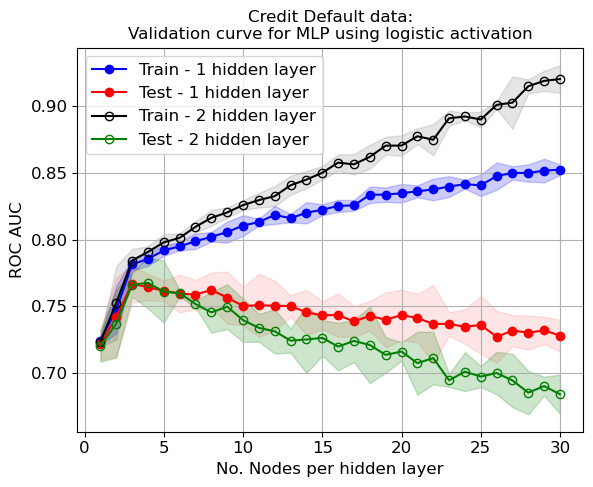

In [21]:
# ====================================
# Repeat with lbfgs solver
# ====================================

#----------------------------------------------------
# A) Hidden layers and nodes per layer
#----------------------------------------------------

activation_list = ['logistic']

for activation in activation_list:
    
    print(activation)
    
    ########################
    ## 1 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []

    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    hidden_layers = 1
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp1l = np.asarray(train_acc_m)
    train_acc_std_mlp1l = np.asarray(train_acc_std)
    test_acc_m_mlp1l = np.asarray(test_acc_m)
    test_acc_std_mlp1l = np.asarray(test_acc_std) 
    
    train_roc_m_mlp1l = np.asarray(train_roc_m)
    train_roc_std_mlp1l = np.asarray(train_roc_std)
    test_roc_m_mlp1l = np.asarray(test_roc_m)
    test_roc_std_mlp1l = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    ########################
    ## 2 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []
    
    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    learning_rate_init=0.001
    hidden_layers = 2
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp2l = np.asarray(train_acc_m)
    train_acc_std_mlp2l = np.asarray(train_acc_std)
    test_acc_m_mlp2l = np.asarray(test_acc_m)
    test_acc_std_mlp2l = np.asarray(test_acc_std) 
    
    train_roc_m_mlp2l = np.asarray(train_roc_m)
    train_roc_std_mlp2l = np.asarray(train_roc_std)
    test_roc_m_mlp2l = np.asarray(test_roc_m)
    test_roc_std_mlp2l = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    fontsize = 12

    # roc_auc
    fig = plt.figure()
    ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
    # Uniform weights
    ax.plot(nodes_list, train_roc_m_mlp1l, 'o-', color='b', label='Train - 1 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp1l - 2*train_roc_std_mlp1l, train_roc_m_mlp1l + 2*train_roc_std_mlp1l, 
                    alpha=0.2, color="b")
    
    ax.plot(nodes_list, test_roc_m_mlp1l, 'o-', color='r', label='Test - 1 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp1l - 2*test_roc_std_mlp1l, test_roc_m_mlp1l + 2*test_roc_std_mlp1l, 
                    alpha=0.1, color="r")
    
    # Distance weights
    ax.plot(nodes_list, train_roc_m_mlp2l, 'o-', color='k', markerfacecolor='none', label='Train - 2 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp2l - 2*train_roc_std_mlp2l, train_roc_m_mlp2l + 2*train_roc_std_mlp2l, 
                    alpha=0.1, color="k")
    
    ax.plot(nodes_list, test_roc_m_mlp2l, 'o-', color='g', markerfacecolor='none', label='Test - 2 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp2l - 2*test_roc_std_mlp2l, test_roc_m_mlp2l + 2*test_roc_std_mlp2l, 
                    alpha=0.2, color="g")
    
    ax.legend(fontsize=fontsize, loc="best")
    ax.tick_params(labelsize=fontsize)
    ax.set_title(f'Credit Default data:\nValidation curve for MLP using {activation} activation', fontsize=fontsize) 
    ax.set_xlabel('No. Nodes per hidden layer', fontsize=fontsize) 
    ax.set_ylabel('ROC AUC', fontsize=fontsize) 
    #ax.set_ylim(0.955, 0.96)
#    ax.set_xticks(list(range(0,22,2)))
    plt.grid(True)
    plt.show()
    fig.savefig(f'mlp-roc_auc-nodes-{activation}.png')
    plt.close(fig)
    

tanh
MLP with 1 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 1 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7680944139972694 at 4 nodes
Maximum accuracy score: 0.8187365911799762 at 1 nodes
MLP with 2 hidden layers
1 nodes
2 nodes
3 nodes
4 nodes
5 nodes
6 nodes
7 nodes
8 nodes
9 nodes
10 nodes
11 nodes
12 nodes
13 nodes
14 nodes
15 nodes
16 nodes
17 nodes
18 nodes
19 nodes
20 nodes
21 nodes
22 nodes
23 nodes
24 nodes
25 nodes
26 nodes
27 nodes
28 nodes
29 nodes
30 nodes
MLP with 2 hidden layers cross validation for number of nodes per hidden layer
Maximum roc_auc score: 0.7609753095366021 at 4 nodes
Maximum accuracy score: 0.8186412395709178 at 1 nodes


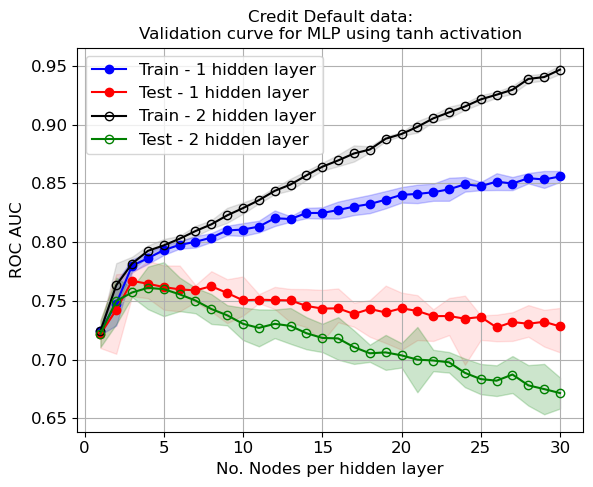

In [22]:
# ====================================
# Repeat with lbfgs solver
# ====================================

#----------------------------------------------------
# A) Hidden layers and nodes per layer
#----------------------------------------------------

activation_list = ['tanh']

for activation in activation_list:
    
    print(activation)
    
    ########################
    ## 1 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []

    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    hidden_layers = 1
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp1t = np.asarray(train_acc_m)
    train_acc_std_mlp1t = np.asarray(train_acc_std)
    test_acc_m_mlp1t = np.asarray(test_acc_m)
    test_acc_std_mlp1t = np.asarray(test_acc_std) 
    
    train_roc_m_mlp1t = np.asarray(train_roc_m)
    train_roc_std_mlp1t = np.asarray(train_roc_std)
    test_roc_m_mlp1t = np.asarray(test_roc_m)
    test_roc_std_mlp1t = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    ########################
    ## 2 hidden layers
    ########################
    
    train_acc_m = []
    train_acc_std = []
    test_acc_m = []
    test_acc_std = []
    
    train_roc_m = []
    train_roc_std = []
    test_roc_m = []
    test_roc_std = []
    
    alpha = 0.0001 # default 0.0001
    max_iter = 1000 # default 200
    tol=1e-6
    learning_rate_init=0.001
    hidden_layers = 2
    print(f'MLP with {hidden_layers} hidden layers')
    
    nodes_list = list(range(1,31,1))
    
    for nodes in nodes_list:
        print(f'{nodes} nodes')
        hidden_layer_sizes = tuple([nodes])*hidden_layers
        clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
        
        scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                                n_jobs=8)
        
    #    for estimator in scores['estimator']:
    #        print(estimator.loss_)
        
        # train and test accuracy
        train_acc_m.append(np.mean(scores['train_accuracy']))
        train_acc_std.append(np.std(scores['train_accuracy']))
        test_acc_m.append(np.mean(scores['test_accuracy']))  
        test_acc_std.append(np.std(scores['test_accuracy']))
                            
        # train and test roc auc
        train_roc_m.append(np.mean(scores['train_roc_auc']))
        train_roc_std.append(np.std(scores['train_roc_auc']))                                        
        test_roc_m.append(np.mean(scores['test_roc_auc']))
        test_roc_std.append(np.std(scores['test_roc_auc']))
    
    train_acc_m_mlp2t = np.asarray(train_acc_m)
    train_acc_std_mlp2t = np.asarray(train_acc_std)
    test_acc_m_mlp2t = np.asarray(test_acc_m)
    test_acc_std_mlp2t = np.asarray(test_acc_std) 
    
    train_roc_m_mlp2t = np.asarray(train_roc_m)
    train_roc_std_mlp2t = np.asarray(train_roc_std)
    test_roc_m_mlp2t = np.asarray(test_roc_m)
    test_roc_std_mlp2t = np.asarray(test_roc_std)
    
    print(f'MLP with {hidden_layers} hidden layers cross validation for number of nodes per hidden layer')
    print(f'Maximum roc_auc score: {max(test_roc_m)} at {nodes_list[test_roc_m.index(max(test_roc_m))]} nodes')
    print(f'Maximum accuracy score: {max(test_acc_m)} at {nodes_list[test_acc_m.index(max(test_acc_m))]} nodes')
    
    fontsize = 12

    # roc_auc
    fig = plt.figure()
    ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
    # Uniform weights
    ax.plot(nodes_list, train_roc_m_mlp1t, 'o-', color='b', label='Train - 1 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp1t - 2*train_roc_std_mlp1t, train_roc_m_mlp1t + 2*train_roc_std_mlp1t, 
                    alpha=0.2, color="b")
    
    ax.plot(nodes_list, test_roc_m_mlp1l, 'o-', color='r', label='Test - 1 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp1t - 2*test_roc_std_mlp1t, test_roc_m_mlp1t + 2*test_roc_std_mlp1t, 
                    alpha=0.1, color="r")
    
    # Distance weights
    ax.plot(nodes_list, train_roc_m_mlp2t, 'o-', color='k', markerfacecolor='none', label='Train - 2 hidden layer')
    ax.fill_between(nodes_list, train_roc_m_mlp2t - 2*train_roc_std_mlp2t, train_roc_m_mlp2t + 2*train_roc_std_mlp2t, 
                    alpha=0.1, color="k")
    
    ax.plot(nodes_list, test_roc_m_mlp2t, 'o-', color='g', markerfacecolor='none', label='Test - 2 hidden layer')
    ax.fill_between(nodes_list, test_roc_m_mlp2t - 2*test_roc_std_mlp2t, test_roc_m_mlp2t + 2*test_roc_std_mlp2t, 
                    alpha=0.2, color="g")
    
    ax.legend(fontsize=fontsize, loc="best")
    ax.tick_params(labelsize=fontsize)
    ax.set_title(f'Credit Default data:\nValidation curve for MLP using {activation} activation', fontsize=fontsize) 
    ax.set_xlabel('No. Nodes per hidden layer', fontsize=fontsize) 
    ax.set_ylabel('ROC AUC', fontsize=fontsize) 
    #ax.set_ylim(0.955, 0.96)
#    ax.set_xticks(list(range(0,22,2)))
    plt.grid(True)
    plt.show()
    fig.savefig(f'mlp-roc_auc-nodes-{activation}.png')
    plt.close(fig)
    

In [40]:
#----------------------------------------------------
# B) MLP regularization term
#----------------------------------------------------
train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []


alpha_list = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
max_iter = 1000 # default 200
tol=1e-6
hidden_layers = 1

for alpha in alpha_list:
    
    clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=[3], 
                            activation='relu', random_state=seed, max_iter=max_iter, tol=tol)
    
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc_ovr'], return_train_score=True, 
                            n_jobs=8)

    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc_ovr']))
    train_roc_std.append(np.std(scores['train_roc_auc_ovr']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc_ovr']))
    test_roc_std.append(np.std(scores['test_roc_auc_ovr']))


train_acc_m_mlp_r1 = np.asarray(train_acc_m)
train_acc_std_mlp_r1 = np.asarray(train_acc_std)
test_acc_m_mlp_r1 = np.asarray(test_acc_m)
test_acc_std_mlp_r1 = np.asarray(test_acc_std) 

train_roc_m_mlp_r1 = np.asarray(train_roc_m)
train_roc_std_mlp_r1 = np.asarray(train_roc_std)
test_roc_m_mlp_r1 = np.asarray(test_roc_m)
test_roc_std_mlp_r1 = np.asarray(test_roc_std)

print(f'MLP with {hidden_layers} hidden layers cross validation for the regularization term')
print(f'Maximum roc_auc score: {max(test_roc_m)} at alpha={alpha_list[test_roc_m.index(max(test_roc_m))]}')
print(f'Maximum accuracy score: {max(test_acc_m)} at alpha={alpha_list[test_acc_m.index(max(test_acc_m))]}')

MLP with 1 hidden layers cross validation for the regularization term
Maximum roc_auc score: 0.7698687887270568 at alpha=0.01
Maximum accuracy score: 0.8179737783075091 at alpha=0.1


In [49]:
#----------------------------------------------------
# B) MLP regularization term - 2 hidden layers
#----------------------------------------------------
train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []


alpha_list = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
max_iter = 1000 # default 200
tol=1e-6
hidden_layers = 2

for alpha in alpha_list:
    
    clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=(6,6), 
                            activation='relu', random_state=seed, max_iter=max_iter, tol=tol)
    
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc_ovr'], return_train_score=True, 
                            n_jobs=8)

    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc_ovr']))
    train_roc_std.append(np.std(scores['train_roc_auc_ovr']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc_ovr']))
    test_roc_std.append(np.std(scores['test_roc_auc_ovr']))


train_acc_m_mlp_a2 = np.asarray(train_acc_m)
train_acc_std_mlp_a2 = np.asarray(train_acc_std)
test_acc_m_mlp_a2 = np.asarray(test_acc_m)
test_acc_std_mlp_a2 = np.asarray(test_acc_std) 

train_roc_m_mlp_a2 = np.asarray(train_roc_m)
train_roc_std_mlp_a2 = np.asarray(train_roc_std)
test_roc_m_mlp_a2 = np.asarray(test_roc_m)
test_roc_std_mlp_a2 = np.asarray(test_roc_std)

print(f'MLP with {hidden_layers} hidden layers cross validation for the regularization term')
print(f'Maximum roc_auc score: {max(test_roc_m)} at alpha={alpha_list[test_roc_m.index(max(test_roc_m))]}')
print(f'Maximum accuracy score: {max(test_acc_m)} at alpha={alpha_list[test_acc_m.index(max(test_acc_m))]}')

MLP with 2 hidden layers cross validation for the regularization term
Maximum roc_auc score: 0.7719511124269773 at alpha=10
Maximum accuracy score: 0.8183075089392133 at alpha=100


In [51]:
#----------------------------------------------------
# B) MLP regularization term - 1 hidden layers 20 nodes
#----------------------------------------------------
train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []


alpha_list = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
max_iter = 1000 # default 200
tol=1e-6
hidden_layers = 1

for alpha in alpha_list:
    
    clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                            hidden_layer_sizes=(20), 
                            activation='relu', random_state=seed, max_iter=max_iter, tol=tol)
    
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc_ovr'], return_train_score=True, 
                            n_jobs=8)

    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc_ovr']))
    train_roc_std.append(np.std(scores['train_roc_auc_ovr']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc_ovr']))
    test_roc_std.append(np.std(scores['test_roc_auc_ovr']))


train_acc_m_mlp_a3 = np.asarray(train_acc_m)
train_acc_std_mlp_a3 = np.asarray(train_acc_std)
test_acc_m_mlp_a3 = np.asarray(test_acc_m)
test_acc_std_mlp_a3 = np.asarray(test_acc_std) 

train_roc_m_mlp_a3 = np.asarray(train_roc_m)
train_roc_std_mlp_a3 = np.asarray(train_roc_std)
test_roc_m_mlp_a3 = np.asarray(test_roc_m)
test_roc_std_mlp_a3 = np.asarray(test_roc_std)

print(f'MLP with {hidden_layers} hidden layers cross validation for the regularization term')
print(f'Maximum roc_auc score: {max(test_roc_m)} at alpha={alpha_list[test_roc_m.index(max(test_roc_m))]}')
print(f'Maximum accuracy score: {max(test_acc_m)} at alpha={alpha_list[test_acc_m.index(max(test_acc_m))]}')

MLP with 1 hidden layers cross validation for the regularization term
Maximum roc_auc score: 0.7662917594607584 at alpha=100
Maximum accuracy score: 0.8167342073897498 at alpha=100


In [48]:
#----------------------------------------------------
# B) MLP grid search
#----------------------------------------------------

alpha_list = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
hidden_layer_sizes = [(3), (4), (5), (6), (3,3), (4,4), (5,4), (6,6), (6,3), (3,2), (4,2)]
mlp = MLPClassifier(solver='lbfgs', activation='relu', random_state=seed, max_iter=1000)
parameters = {'hidden_layer_sizes':hidden_layer_sizes, 'alpha':alpha_list}
clf = GridSearchCV(mlp, param_grid=parameters, scoring = ['roc_auc_ovr'], n_jobs=8, cv=5, return_train_score=True, 
                   refit='roc_auc_ovr', verbose=3)
clf.fit(X_train, y_train)
print('MLP best fit')
print(clf.best_params_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
MLP best fit
{'alpha': 10, 'hidden_layer_sizes': (6, 6)}


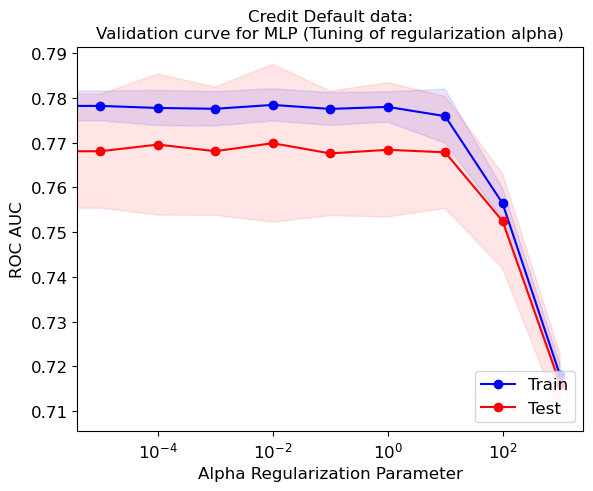

In [41]:
fontsize = 12

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
ax.plot(alpha_list, train_roc_m_mlp_r1, 'o-', color='b', label='Train')
ax.fill_between(alpha_list, train_roc_m_mlp_r1 - 2*train_roc_std_mlp_r1, train_roc_m_mlp_r1 + 2*train_roc_std_mlp_r1, 
                alpha=0.1, color="b")

ax.plot(alpha_list, test_roc_m_mlp_r1, 'o-', color='r', label='Test')
ax.fill_between(alpha_list, test_roc_m_mlp_r1 - 2*test_roc_std_mlp_r1, test_roc_m_mlp_r1 + 2*test_roc_std_mlp_r1, 
                alpha=0.1, color="r")

ax.set_xscale("log", base=10)
ax.legend(fontsize=fontsize, loc="lower right")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data:\nValidation curve for MLP (Tuning of regularization alpha)', fontsize=fontsize) 
ax.set_xlabel('Alpha Regularization Parameter', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
plt.show()
fig.savefig('mlp-roc_auc_alpha.png')
plt.close(fig)


In [42]:
#----------------------------------------------------
# B) Activation
#----------------------------------------------------
train_acc_m = []
train_acc_std = []
test_acc_m = []
test_acc_std = []

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []


activation_list = ['identity', 'logistic', 'tanh', 'relu']
max_iter = 1000 # default 200
tol=1e-6
hidden_layers = 1

for activation in activation_list:
    clf = MLPClassifier(solver='lbfgs', alpha=0.01, 
                        hidden_layer_sizes=[3], 
                        activation=activation, random_state=seed, max_iter=max_iter, tol=tol)
    
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['accuracy','roc_auc'], return_train_score=True, 
                            n_jobs=8)

    # train and test accuracy
    train_acc_m.append(np.mean(scores['train_accuracy']))
    train_acc_std.append(np.std(scores['train_accuracy']))
    test_acc_m.append(np.mean(scores['test_accuracy']))  
    test_acc_std.append(np.std(scores['test_accuracy']))
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

train_acc_m_mlp_r2 = np.asarray(train_acc_m)
train_acc_std_mlp_r2 = np.asarray(train_acc_std)
test_acc_m_mlp_r2 = np.asarray(test_acc_m)
test_acc_std_mlp_r2 = np.asarray(test_acc_std) 

train_roc_m_mlp_r2 = np.asarray(train_roc_m)
train_roc_std_mlp_r2 = np.asarray(train_roc_std)
test_roc_m_mlp_r2 = np.asarray(test_roc_m)
test_roc_std_mlp_r2 = np.asarray(test_roc_std)

print(f'MLP with {hidden_layers} hidden layers cross validation for the activation function')
print(f'Maximum roc_auc score: {max(test_roc_m)} at activation={activation_list[test_roc_m.index(max(test_roc_m))]}')
print(f'Maximum accuracy score: {max(test_acc_m)} at activation={activation_list[test_acc_m.index(max(test_acc_m))]}')

MLP with 1 hidden layers cross validation for the activation function
Maximum roc_auc score: 0.7698687887270568 at activation=relu
Maximum accuracy score: 0.8181644815256257 at activation=logistic


In [52]:
test_roc_m_mlp_r2

array([0.7205961 , 0.76722762, 0.76570895, 0.76986879])

In [53]:
train_roc_m_mlp_r2

array([0.72339701, 0.78145657, 0.77977908, 0.77842541])

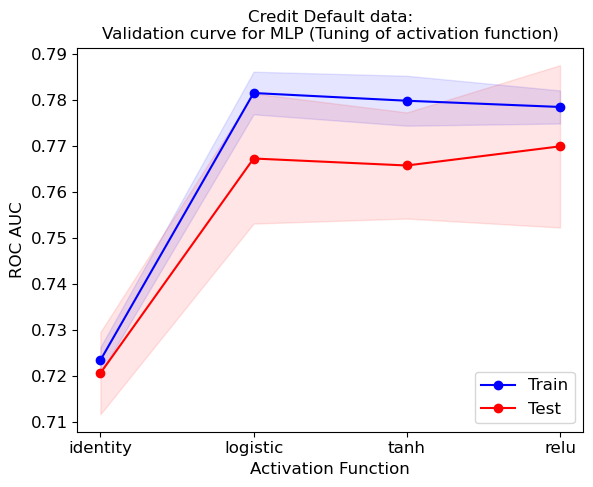

In [43]:
fontsize = 12

# roc_auc
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.79, 0.80])
ax.plot(activation_list, train_roc_m_mlp_r2, 'o-', color='b', label='Train')
ax.fill_between(activation_list, train_roc_m_mlp_r2 - 2*train_roc_std_mlp_r2, train_roc_m_mlp_r2 + 2*train_roc_std_mlp_r2, 
                alpha=0.1, color="b")

ax.plot(activation_list, test_roc_m_mlp_r2, 'o-', color='r', label='Test')
ax.fill_between(activation_list, test_roc_m_mlp_r2 - 2*test_roc_std_mlp_r2, test_roc_m_mlp_r2 + 2*test_roc_std_mlp_r2, 
                alpha=0.1, color="r")

ax.legend(fontsize=fontsize, loc="lower right")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data:\nValidation curve for MLP (Tuning of activation function)', fontsize=fontsize) 
ax.set_xlabel('Activation Function', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
plt.show()
fig.savefig('mlp-roc_auc_activation.png')
plt.close(fig)

In [64]:
# ====================================
# MLP iterative learning curves
# ====================================

train_roc_m = []
train_roc_std = []
test_roc_m = []
test_roc_std = []

max_iter_list = [1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50] + list(range(100,1100,100))
hidden_layers = 1
nodes = 3

for max_iter in max_iter_list:
#    print(f'max_iter={max_iter}')
    clf = MLPClassifier(solver='lbfgs', max_iter=max_iter, alpha=0.01, hidden_layer_sizes=tuple([nodes])*hidden_layers, 
                    activation='relu', random_state=seed, tol=1e-20)
    
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring = ['roc_auc'], return_train_score=True, n_jobs=8)
                        
    # train and test roc auc
    train_roc_m.append(np.mean(scores['train_roc_auc']))
    train_roc_std.append(np.std(scores['train_roc_auc']))                                        
    test_roc_m.append(np.mean(scores['test_roc_auc']))
    test_roc_std.append(np.std(scores['test_roc_auc']))

train_roc_m_mlp_iter = np.asarray(train_roc_m)
train_roc_std_mlp_iter = np.asarray(train_roc_std)
test_roc_m_mlp_iter = np.asarray(test_roc_m)
test_roc_std_mlp_iter = np.asarray(test_roc_std)
    
print(f'MLP number of iteration')
print(f'Maximum roc_auc score: {max(test_roc_m)} at {max_iter_list[test_roc_m.index(max(test_roc_m))]} iterations')

MLP number of iteration
Maximum roc_auc score: 0.7700159757442385 at 400 iterations


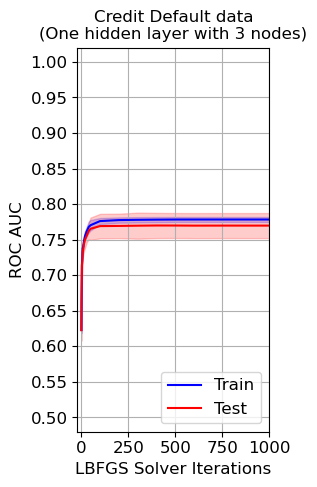

In [109]:
fontsize = 12

# roc_auc
fig = plt.figure(figsize=(3.2,4.8))
ax = fig.add_axes([0.24, 0.11, 0.60, 0.80])
ax.plot(max_iter_list, train_roc_m_mlp_iter, color='b', label='Train')
ax.fill_between(max_iter_list, train_roc_m_mlp_iter - 2*train_roc_std_mlp_iter, train_roc_m_mlp_iter + 2*train_roc_std_mlp_iter, 
                alpha=0.2, color="b")

ax.plot(max_iter_list, test_roc_m_mlp_iter, color='r', label='Test')
ax.fill_between(max_iter_list, test_roc_m_mlp_iter - 2*test_roc_std_mlp_iter, test_roc_m_mlp_iter + 2*test_roc_std_mlp_iter, 
                alpha=0.2, color="r")

ax.legend(fontsize=fontsize, loc="lower right")
ax.tick_params(labelsize=fontsize)
ax.set_title('Credit Default data\n(One hidden layer with 3 nodes)', fontsize=fontsize) 
ax.set_xlabel('LBFGS Solver Iterations', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
ax.set_xlim(-20, 1000)
ax.set_ylim(0.48, 1.02)
ax.set_xticks(np.arange(0,1250,250))
ax.set_yticks(np.arange(0.5,1.05,0.05))
plt.grid(True)
plt.show()
fig.savefig('mlp-roc_auc_iter_learning.png')
plt.close(fig)

### Learning curves

In [92]:
# KNN learning curves
clf = KNeighborsClassifier(n_neighbors=200, weights='distance', p=1) 
train_sizes = np.arange(5,105,5)*0.01*X_train.shape[0]*0.80
train_sizes = train_sizes.astype(int)
train_sizes2 = [33, 67, 134, 201, 268] + train_sizes.tolist()
train_sizes_knn, train_scores_knn, validation_scores_knn = learning_curve(
estimator = clf,
X = X_train,
y = y_train, train_sizes = train_sizes2, cv = 5,
scoring = 'roc_auc', shuffle = True, n_jobs=8, random_state=seed)

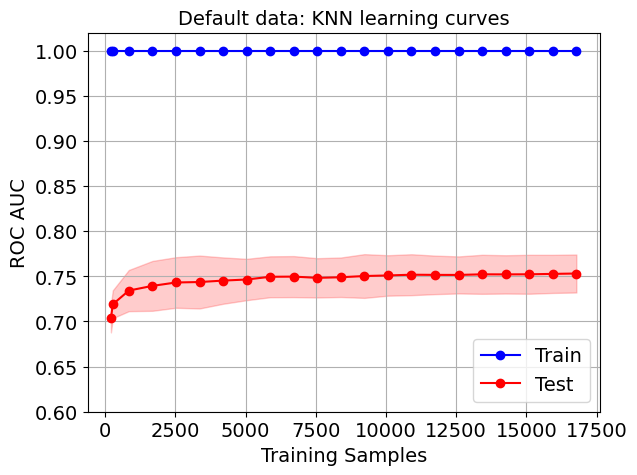

In [130]:
train_mean = train_scores_knn.mean(axis = 1)
train_std = train_scores_knn.std(axis = 1)
test_mean = validation_scores_knn.mean(axis = 1)
test_std = validation_scores_knn.std(axis = 1)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.8, 0.79])
ax.plot(train_sizes_knn, train_mean, '-o', label='Train', color="b")
ax.fill_between(train_sizes_knn, train_mean - 2*train_std, train_mean + 2*train_std, 
                alpha=0.1, color="b")
ax.plot(train_sizes_knn, test_mean, '-o', label='Test', color="r")
ax.fill_between(train_sizes_knn, test_mean - 2*test_std, test_mean + 2*test_std, 
                alpha=0.2, color="r")
ax.legend(fontsize=fontsize, loc="lower right") 
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: KNN learning curves', fontsize=fontsize) 
ax.set_xlabel('Training Samples', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
#ax.set_xlim(0, 500)
#ax.set_xticks(np.arange(0,600,100))
ax.set_ylim(0.60, 1.02)
ax.set_yticks(np.arange(0.60,1.05,0.05))
plt.grid(True)
plt.show()
fig.savefig('knn-learning_curves-roc_auc.png')
plt.close(fig)

In [91]:
# SVM learning curves
clf = svm.SVC(kernel='rbf', gamma='scale', C=0.0001, random_state=seed)  
train_sizes = np.arange(5,105,5)*0.01*X_train.shape[0]*0.80
train_sizes = train_sizes.astype(int)
train_sizes2 = [33, 67, 134, 201, 268] + train_sizes.tolist()
train_sizes_svm, train_scores_svm, validation_scores_svm = learning_curve(
estimator = clf,
X = X_train,
y = y_train, train_sizes = train_sizes2, cv = 5,
scoring = 'roc_auc', shuffle = True, n_jobs=8, random_state=seed)

In [89]:
train_sizes_svm

array([   67,   134,   201,   268,   839,  1678,  2517,  3356,  4195,
        5034,  5873,  6712,  7551,  8390,  9229, 10068, 10907, 11746,
       12585, 13424, 14263, 15102, 15941, 16780])

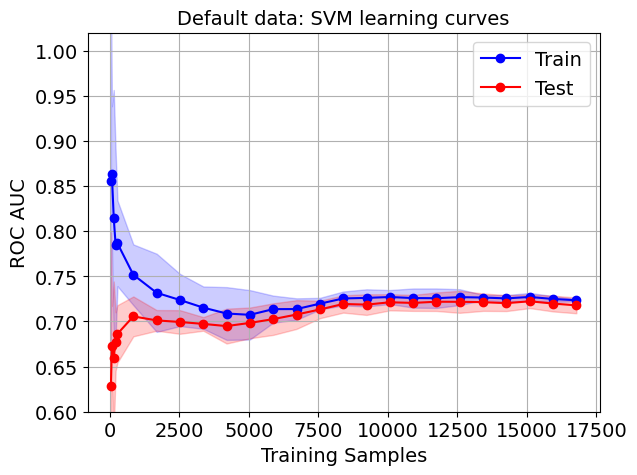

SVM
Maximum roc_auc score: 0.7223127543340947 at 15102 train samples


In [128]:
train_mean = train_scores_svm.mean(axis = 1)
train_std = train_scores_svm.std(axis = 1)
test_mean = validation_scores_svm.mean(axis = 1)
test_std = validation_scores_svm.std(axis = 1)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.8, 0.79])
ax.plot(train_sizes_svm, train_mean, '-o', label='Train', color="b")
ax.fill_between(train_sizes_svm, train_mean - 2*train_std, train_mean + 2*train_std, 
                alpha=0.2, color="b")
ax.plot(train_sizes_svm, test_mean, '-o', label='Test', color="r")
ax.fill_between(train_sizes_svm, test_mean - 2*test_std, test_mean + 2*test_std, 
                alpha=0.2, color="r")
ax.legend(fontsize=fontsize, loc="upper right")
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: SVM learning curves', fontsize=fontsize) 
ax.set_xlabel('Training Samples', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
#ax.set_xlim(0, 500)
#ax.set_xticks(np.arange(0,600,100))
ax.set_ylim(0.60, 1.02)
ax.set_yticks(np.arange(0.60,1.05,0.05))
plt.grid(True)
plt.show()
fig.savefig('svm-learning_curves-roc_auc.png')
plt.close(fig)

print(f'SVM')
test_mean_list = test_mean.tolist()
train_sizes_list = train_sizes_svm.tolist()
print(f'Maximum roc_auc score: {max(test_mean_list)} at {train_sizes_list[test_mean_list.index(max(test_mean_list))]} train samples')

In [94]:
# MLP learning curves
clf = MLPClassifier(solver='lbfgs', 
                    hidden_layer_sizes=[3], 
                    activation='relu', random_state=seed, alpha=0.01, max_iter=400, tol=1e-6) 

train_sizes = np.arange(5,105,5)*0.01*X_train.shape[0]*0.80
train_sizes = train_sizes.astype(int)
train_sizes2 = [33, 67, 134, 201, 268] + train_sizes.tolist()
train_sizes_mlp, train_scores_mlp, validation_scores_mlp = learning_curve(
estimator = clf,
X = X_train,
y = y_train, train_sizes = train_sizes2, cv = 5,
scoring = 'roc_auc', shuffle = True, n_jobs=8, random_state=seed)

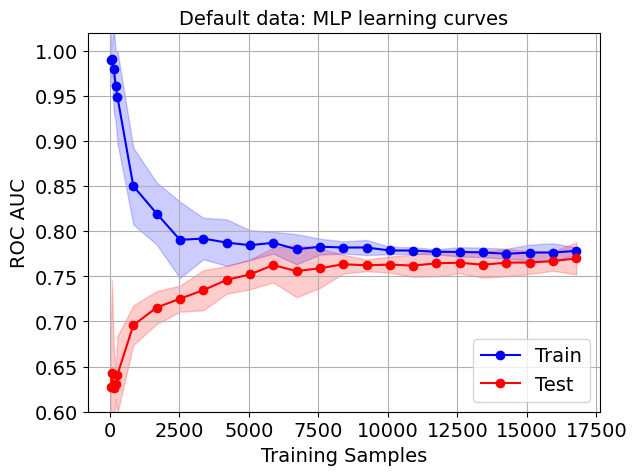

In [129]:
train_mean = train_scores_mlp.mean(axis = 1)
train_std = train_scores_mlp.std(axis = 1)
test_mean = validation_scores_mlp.mean(axis = 1)
test_std = validation_scores_mlp.std(axis = 1)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.8, 0.79])
ax.plot(train_sizes_mlp, train_mean, '-o', label='Train', color="b")
ax.fill_between(train_sizes_mlp, train_mean - 2*train_std, train_mean + 2*train_std, 
                alpha=0.2, color="b")
ax.plot(train_sizes_mlp, test_mean, '-o', label='Test', color="r")
ax.fill_between(train_sizes_mlp, test_mean - 2*test_std, test_mean + 2*test_std, 
                alpha=0.2, color="r")
ax.legend(fontsize=fontsize, loc="lower right")
ax.tick_params(labelsize=fontsize)
ax.set_title('Default data: MLP learning curves', fontsize=fontsize) 
ax.set_xlabel('Training Samples', fontsize=fontsize) 
ax.set_ylabel('ROC AUC', fontsize=fontsize) 
#ax.set_xlim(0, 500)
#ax.set_xticks(np.arange(0,600,100))
ax.set_ylim(0.60, 1.02)
ax.set_yticks(np.arange(0.60,1.05,0.05))
plt.grid(True)
plt.show()
fig.savefig('MLP-learning_curves-roc_auc.png')
plt.close(fig)

In [106]:
# FINAL TRAINING and TEST

# KNN
clf = KNeighborsClassifier(n_neighbors=200, weights='distance', p=1)

tic = time.perf_counter()
clf.fit(X_train, y_train)
toc = time.perf_counter()
knn_train_time = toc-tic

tic = time.perf_counter()
y_pred_train_knn = clf.predict(X_train)
toc = time.perf_counter()
knn_pred_train_time = toc-tic

tic = time.perf_counter()
y_pred_test_knn = clf.predict(X_test)
toc = time.perf_counter()
knn_pred_test_time = toc-tic

train_acc_knn = accuracy_score(y_train, y_pred_train_knn)
test_acc_knn = accuracy_score(y_test, y_pred_test_knn)

train_roc_knn = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
test_roc_knn = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('kNN training and test')
print(f'train accuracy: {train_acc_knn}') 
print(f'train roc_auc: {train_roc_knn}')

print(f'test accuracy: {test_acc_knn}')
print(f'test roc_auc: {test_roc_knn}') 

print(f'Time to train: {knn_train_time}')
print(f'Time to predict training set: {knn_pred_train_time}') 
print(f'Time to predict test set: {knn_pred_test_time}') 

# SVM
clf = svm.SVC(kernel='rbf', gamma='scale', C=0.0001, random_state=seed, probability=True)

tic = time.perf_counter()
clf.fit(X_train, y_train)
toc = time.perf_counter()
svm_train_time = toc-tic

tic = time.perf_counter()
y_pred_train_svm = clf.predict(X_train)
toc = time.perf_counter()
svm_pred_train_time = toc-tic

tic = time.perf_counter()
y_pred_test_svm = clf.predict(X_test)
toc = time.perf_counter()
svm_pred_test_time = toc-tic

train_acc_svm = accuracy_score(y_train, y_pred_train_svm)
test_acc_svm = accuracy_score(y_test, y_pred_test_svm)

train_roc_svm = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
test_roc_svm = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('\nSVM training and test')
print(f'train accuracy: {train_acc_svm}') 
print(f'train roc_auc: {train_roc_svm}')

print(f'test accuracy: {test_acc_svm}')
print(f'test roc_auc: {test_roc_svm}') 

print(f'Time to train: {svm_train_time}')
print(f'Time to predict training set: {svm_pred_train_time}') 
print(f'Time to predict test set: {svm_pred_test_time}') 

# MLP
clf = MLPClassifier(solver='lbfgs', 
                    hidden_layer_sizes=[3], 
                    activation='relu', random_state=seed, alpha=0.01, max_iter=400, tol=1e-6) 

tic = time.perf_counter()
clf.fit(X_train, y_train)
toc = time.perf_counter()
mlp_train_time = toc-tic

tic = time.perf_counter()
y_pred_train_mlp = clf.predict(X_train)
toc = time.perf_counter()
mlp_pred_train_time = toc-tic

tic = time.perf_counter()
y_pred_test_mlp = clf.predict(X_test)
toc = time.perf_counter()
mlp_pred_test_time = toc-tic

train_acc_mlp = accuracy_score(y_train, y_pred_train_mlp)
test_acc_mlp = accuracy_score(y_test, y_pred_test_mlp)

train_roc_mlp = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
test_roc_mlp = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('\nMLP training and test')
print(f'train accuracy: {train_acc_mlp}') 
print(f'train roc_auc: {train_roc_mlp}')

print(f'test accuracy: {test_acc_mlp}')
print(f'test roc_auc: {test_roc_mlp}') 

print(f'Time to train: {mlp_train_time}')
print(f'Time to predict training set: {mlp_pred_train_time}') 
print(f'Time to predict test set: {mlp_pred_test_time}') 

kNN training and test
train accuracy: 0.9995709177592372
train roc_auc: 0.9999994657421606
test accuracy: 0.8043381535038933
test roc_auc: 0.7610539225560609
Time to train: 0.005232599971350282
Time to predict training set: 2.2368507999926805
Time to predict test set: 2.625215100008063

SVM training and test
train accuracy: 0.7787365911799762
train roc_auc: 0.7210061568401084
test accuracy: 0.7787541713014461
test roc_auc: 0.7225553643166253
Time to train: 75.29604079999262
Time to predict training set: 741.1199093999458
Time to predict test set: 318.80323249998037

MLP training and test
train accuracy: 0.8190226460071514
train roc_auc: 0.7770136593503947
test accuracy: 0.8205784204671858
test roc_auc: 0.7796905261469147
Time to train: 3.2536720000207424
Time to predict training set: 0.0022566000116057694
Time to predict test set: 0.0015321000246331096


C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [107]:
# SVM without probability predict
clf = svm.SVC(kernel='rbf', gamma='scale', C=0.0001, random_state=seed)

tic = time.perf_counter()
clf.fit(X_train, y_train)
toc = time.perf_counter()
svm_train_time = toc-tic

tic = time.perf_counter()
y_pred_train_svm = clf.predict(X_train)
toc = time.perf_counter()
svm_pred_train_time = toc-tic

tic = time.perf_counter()
y_pred_test_svm = clf.predict(X_test)
toc = time.perf_counter()
svm_pred_test_time = toc-tic

print('\nSVM training and test (without predicting probabilities)')

print(f'Time to train: {svm_train_time}')
print(f'Time to predict training set: {svm_pred_train_time}') 
print(f'Time to predict test set: {svm_pred_test_time}') 


SVM training and test (without predicting probabilities)
Time to train: 9.919146700005513
Time to predict training set: 801.7230016000103
Time to predict test set: 336.0061750000459


In [ ]:
X_df.columns